**부동산 가격 예측**
---
> **목차(Context)**

* 문제상황 및 데이터 살펴보기
* 문제해결 프로세스 정의
* 🥉Session 1 - 「Data 전처리 및 EDA」
* 🥈Session 2 - 「Feature Selection」
* 🥇Session 3 - 「TabNe, XGBoost, MLP 활용 소득 예측」

In [ ]:
# Tabnet 설치
!pip install pytorch-tabnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 1.3 MB/s eta 0:00:00


In [ ]:
# 초기설정

# ▶ Warnings 제거
import warnings
warnings.filterwarnings('ignore')

# ▶ Google drive mount or 폴더 클릭 후 구글드라이브 연결
from google.colab import drive
drive.mount('/content/drive')

# ▶ 경로 설정 (※ Colab을 활성화시켰다면 보통 Colab Notebooks 폴더가 자동 생성)
import os
os.chdir("/content/drive/MyDrive/Colab Notebooks")
os.getcwd()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/drive/MyDrive/Colab Notebooks'

> **데이터**
* 주택 관련 데이터
* 데이터 명세 ⬇
* https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data

## **문제해결 프로세스 정의**
---
> **문제정의**

```
▶ 주택 매입 시 적정 금액 산정 어려움
```  

> **기대효과**

```
▶ 주태 매입 시 표준금액(base-line) 활용 및 적정 금액으로 매수
```

> **해결방안**

```
▶ 주택 가격 예측 모델링을 통한 적정 주택 가격 산정
▶ Session 1 🥉
 - Data 전처리 및 EDA
▶ Session 2 🥈
 - 유의미한 변수를 찾는 Feature Selection
▶ Session 3 🥇
 - TabNet 알고리즘 사용 부동산 가격 예측 모델링 수행
```

> **성과측정**  

```
▶ 모델 운용 전/후 평균 부동산(동일 범주의 건물) 매입 가격 비교
```

> **현업적용**  

```
▶ 부동산 매입 시 매입 가격 선정 시 활용
```

## **🥉Session 1**  
**┗ Data 전처리 및 EDA**  
---

### · Data 전처리  
---
* 수집된 데이터의 기본 정보들을 확인  

  (1) Data shape(형태) 확인

  (2) Data type 확인

  (3) Null값 확인 (※ 빈 값의 Data)

  (4) Outlier 확인 (※ 정상적인 범주를 벗어난 Data)

In [ ]:
# ▶ pd.set option
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)

# ▶ Data read
train_df = pd.read_csv('train.csv')
test_df  = pd.read_csv('test.csv')
solution_df = pd.read_csv('solution.csv')

%matplotlib inline
plt.style.use(['dark_background'])

In [ ]:
# MLP Model 초기 설정
import torch
import os
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

import random
import torch.backends.cudnn as cudnn

# 랜덤변수 고정
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
np.random.seed(0)
cudnn.benchmark = False
cudnn.deterministic = True
random.seed(0)

|Column|Description|
|:---|:---|
|SalePrice|부동산 판매가격|
|MSSubClass|빌딩 클래스|
|MSZoning|일반 구역 분류|
|LotFrontage|부동산에 연결된 거리의 선형 피트|
|LotArea|로트 크기(제곱 피트)|
|Street|도로 접근 유형|
|Alley|골목길 접근 유형|
|LotShape|속성의 일반 형태|
|LandContour|부동산의 평탄성|
|Utilities|사용 가능한 유틸리티 유형|
|LotConfig|Lot 구성|
|LandSlope|토지 경사|
|Neighborhood|이웃의 물리적 위치|
|Condition1|간선 도로 또는 철도에 대한 근접성|
|Condition2|간선 도로 또는 철도에 대한 근접성(두 번째가 있는 경우)|
|BldgType|주거 유형|
|HouseStyle|주거 스타일|
|OverallQual|전체 재료 및 마감 품질|
|OverallCond|종합조건등급|
|YearBuilt|시공연도|
|YearRemodAdd|리모델링 날짜|
|RoofStyle|지붕 스타일|
|RoofMatl|지붕 재료|
|Exterior1st|주택외부재질|
|Exterior2nd|주택외부재질(재질이 여러개인 경우)|
|MasVnrType|석조베니어 타입|
|MasVnrArea|석조베니어 영역|
|ExterQual|외장재 품질|
|ExterCond|외부재료 상태|
|Foundation|기초의 종류|
|BsmtQual|지하실 높이|
|BsmtCond|지하실 상태|
|BsmtExposure|워크아웃 또는 정원수준의 지하 벽|
|BsmtFinType1|지하 마감구역 품질|
|BsmtFinSF1|타입1 마감 평방 피트|
|BsmtFinType2|두 번째 마감구역 품질(있는 경우)|
|BsmtFinSF2|타입2 마감 평방 피트|
|BsmtUnfSF|미완성 지하 면적 평방 피트|
|TotalBsmtSF|청 지하 면적 평방 피트|
|Heating|난방 종류|
|HeatingQC|난방 품질 및 상태|
|CentralAir|중앙 에어컨|
|Electrical|전기 시스템|
|1stFlrSF|1층 평방 피트|
|2ndFlrSF|2층 평방 피트|
|LowQualFinSF|저품질 마감 평방 피트(전체 층)|
|GrLivArea|지상 거주면적 평방 피트|
|BsmtFullBath|지하실 전체 욕실|
|BsmtHalfBath|지하실 하프 욕실|
|FullBath|전체 욕실|
|HalfBath|하프 욕실|
|Bedroom|침실|
|Kitchen|주방|
|KitchenQual|주방품질|
|TotRmsAbvGrd|총 객실|
|Functional|홈 기능 등급|
|Fireplaces|벽난로|
|FireplaceQu|벽난로 품질|
|GarageType|차고 유형|
|GarageYrBlt|차고 준공년도|
|GarageFinish|차고 내부마감|
|GarageCars|자동차 차고 크기|
|GarageArea|차고 면적(평방 피트)|
|GarageQual|차고 품질|
|GarageCond|차고 상태|
|PavedDrive|포장 진입로|
|WoodDeckSF|목재 데크 면적|
|OpenPorchSF|현관 영역|
|EnclosedPorch|밀폐형 현관 면적|
|3SsnPorch|3계절 현관 면적|
|ScreenPorch|스크린 포트|
|PoolArea|풀 면적|
|PoolQC|풀 품질|
|Fence|울타리 품질|
|MiscFeature|기타기능|
|MiscVal|기타기능의 가치|
|MoSold|월 별 판매|
|YrSold|판매연도|
|SaleType|판매종류|
|SaleCondition|판매조건|

<Axes: xlabel='SalePrice', ylabel='Density'>

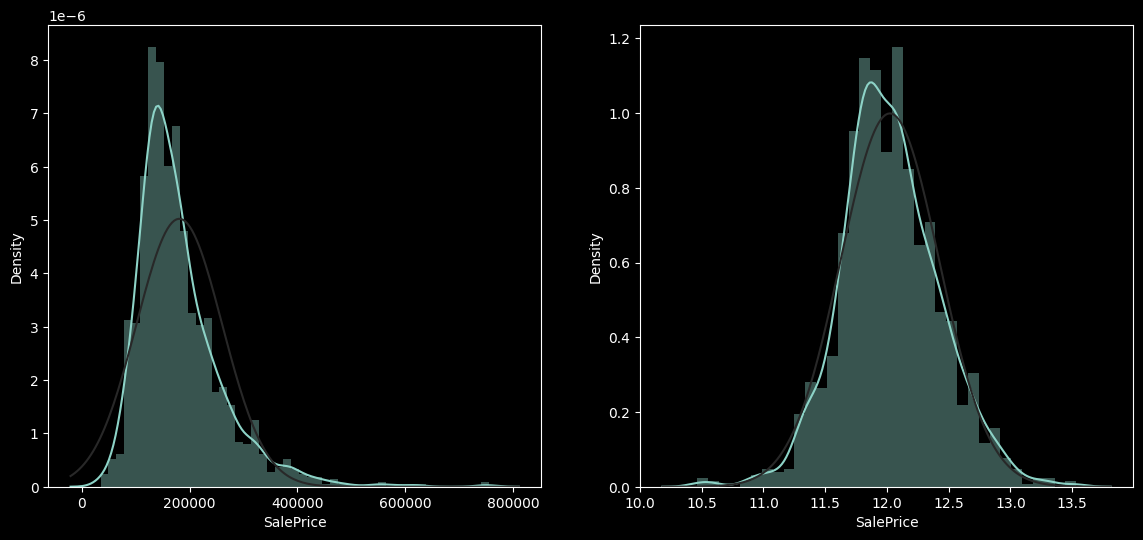

In [ ]:
# 타겟 데이터 분포 확인
figure, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(14,6)
sns.distplot(train_df['SalePrice'], fit=norm, ax=ax1)
sns.distplot(np.log(train_df['SalePrice']+1), fit=norm, ax=ax2)

In [ ]:
from scipy.stats import skew, kurtosis

print("SalePrice skew:", skew(train_df['SalePrice']))
print("SalePrice kurtosis:", kurtosis(train_df['SalePrice'], fisher=True))

SalePrice skew: 1.880940746034036
SalePrice kurtosis: 6.509812011089439


In [ ]:
# test_df left join solution_df
test_df = pd.merge(test_df, solution_df, how='left', on='Id')
test_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000.0
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000.0
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900.0
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal,195500.0
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal,191500.0


In [ ]:
# train concat test data Concat
df = pd.concat([train_df, test_df],axis=0)
df.shape

(2919, 81)

In [ ]:
# 데이터 형태 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   int64  
 2   MSZoning       2915 non-null   object 
 3   LotFrontage    2433 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   Alley          198 non-null    object 
 7   LotShape       2919 non-null   object 
 8   LandContour    2919 non-null   object 
 9   Utilities      2917 non-null   object 
 10  LotConfig      2919 non-null   object 
 11  LandSlope      2919 non-null   object 
 12  Neighborhood   2919 non-null   object 
 13  Condition1     2919 non-null   object 
 14  Condition2     2919 non-null   object 
 15  BldgType       2919 non-null   object 
 16  HouseStyle     2919 non-null   object 
 17  OverallQual    2919 non-null   int64  
 18  OverallC

In [ ]:
# 결측치 확인
print(df.isnull().sum())

Id                  0
MSSubClass          0
MSZoning            4
LotFrontage       486
LotArea             0
Street              0
Alley            2721
LotShape            0
LandContour         0
Utilities           2
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         1
Exterior2nd         1
MasVnrType         24
MasVnrArea         23
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           81
BsmtCond           82
BsmtExposure       82
BsmtFinType1       79
BsmtFinSF1          1
BsmtFinType2       80
BsmtFinSF2          1
BsmtUnfSF           1
TotalBsmtSF         1
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
1stFlrSF            0
2ndFlrSF            0
LowQualFin

In [ ]:
# ▶ numeric, categorical value 나누기
numerical_list=[]
categorical_list=[]

for i in df.columns :
  if df[i].dtypes == 'O' :
    categorical_list.append(i)
  else :
    numerical_list.append(i)

print("categorical_list :", categorical_list)
print("numerical_list :", numerical_list)

categorical_list : ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
numerical_list : ['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageA

In [ ]:
# ▶ 숫자형 변수에 경우 평균 값을 대체, 문자형 변수의 경우 'None'로 대체
# ▶ n_features 변환
df[numerical_list] = df[numerical_list].apply(lambda x: x.fillna(x.mean()),axis=0)

# ▶ c_features 변환
df[categorical_list] = df[categorical_list].apply(lambda x: x.fillna('None'),axis=0)

In [ ]:
# Null 값 재 확인
df.isnull().sum().sum()

0

In [ ]:
# ▶ Outlier 확인
df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000
mean,1460.000000,57.137718,69.305795,10168.114080,6.089072,5.564577,1971.312778,1984.264474,102.201312,441.423235,49.582248,560.772104,1051.777587,1159.581706,336.483727,4.694416,1500.759849,0.429894,0.061364,1.568003,0.380267,2.860226,1.044536,6.451524,0.597122,1978.113406,1.766621,472.874572,93.709832,47.486811,23.098321,2.602261,16.062350,2.251799,50.825968,6.213087,2007.792737,180707.333333
std,842.787043,42.517628,21.312345,7886.996359,1.409947,1.113131,30.291442,20.894344,178.626089,455.532750,169.176615,439.468337,440.690726,392.362079,428.701456,46.396825,506.051045,0.524556,0.245603,0.552969,0.502872,0.822693,0.214462,1.569379,0.646129,24.867762,0.761494,215.357904,126.526589,67.575493,64.244246,25.188169,56.184365,35.663946,567.402211,2.714762,1.314964,79970.412811
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1895.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,12789.000000
25%,730.500000,20.000000,60.000000,7478.000000,5.000000,5.000000,1953.500000,1965.000000,0.000000,0.000000,0.000000,220.000000,793.000000,876.000000,0.000000,0.000000,1126.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.500000,1.000000,320.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129325.000000
50%,1460.000000,50.000000,69.305795,9453.000000,6.000000,5.000000,1973.000000,1993.000000,0.000000,369.000000,0.000000,467.000000,990.000000,1082.000000,0.000000,0.000000,1444.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1978.113406,2.000000,480.000000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,160000.000000
75%,2189.500000,70.000000,78.000000,11570.000000,7.000000,6.000000,2001.000000,2004.000000,163.500000,733.000000,0.000000,805.000000,1302.000000,1387.500000,704.000000,0.000000,1743.500000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2001.000000,2.000000,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,213495.000000
max,2919.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1526.000000,2336.000000,6110.000000,5095.000000,2065.000000,1064.000000,5642.000000,3.000000,2.000000,4.000000,2.000000,8.000000,3.000000,15.000000,4.000000,2207.000000,5.000000,1488.000000,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000,755000.000000


## **🥈Session 2**  
**┗ Feature Selection & EDA**  
---

### · 숫자형 변수와 타겟 관계 탐색
---
* corr() 활용 상관관계 분석

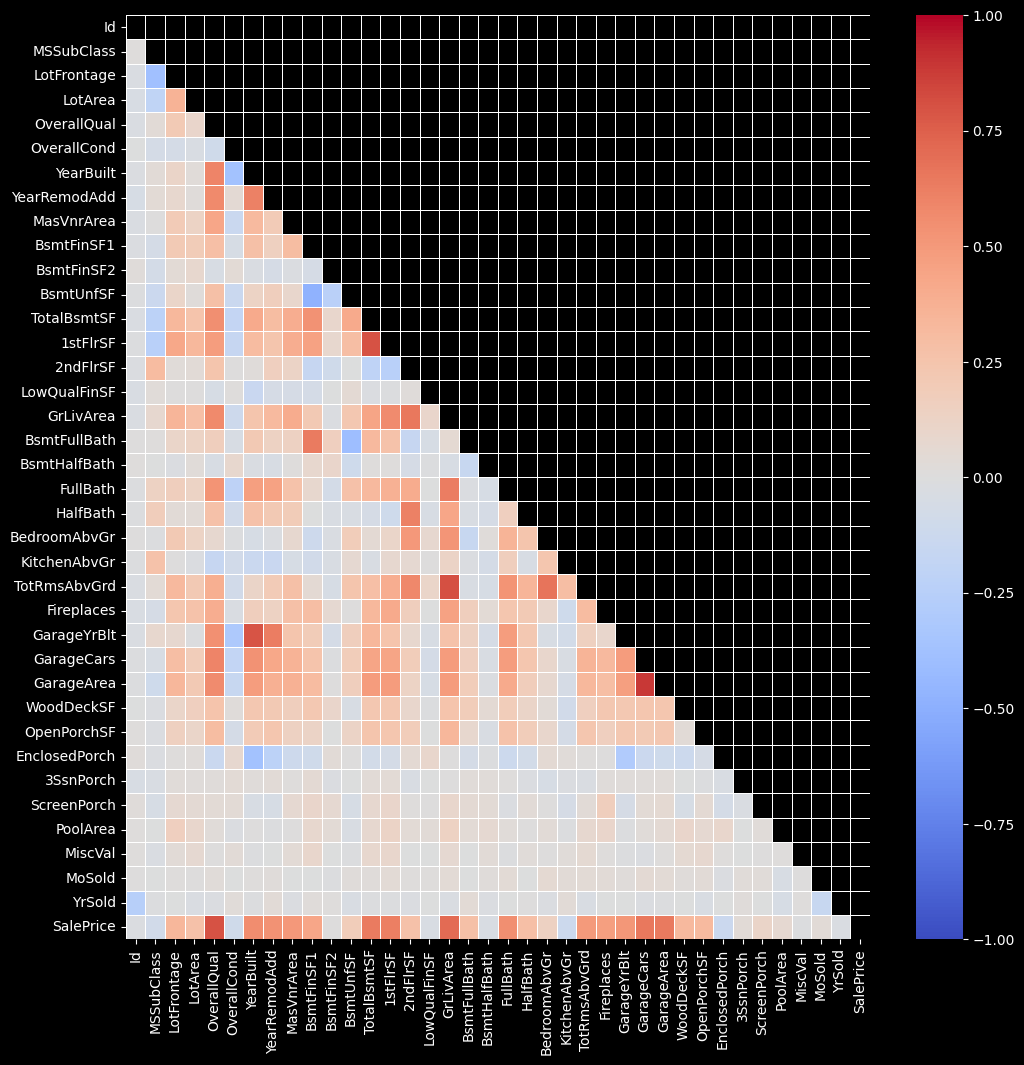

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# ▶ corr() 활용, numerical value 상관관계 확인
fig = plt.figure(figsize=(12,12))
df_num = df[numerical_list].corr()
sns.heatmap(df_num, vmin = -1, vmax = +1, annot = False, cmap = 'coolwarm', linewidths=.5,mask=np.triu(df_num.corr()));

In [ ]:
# 상관계수 중 target 변수인 SalePrice 열(col)만 가져오기
df_corr_y = pd.DataFrame(df_num['SalePrice'].sort_values(ascending=False))
df_corr_y

,SalePrice
SalePrice,1.000000
OverallQual,0.800888
GrLivArea,0.708096
GarageCars,0.649497
GarageArea,0.641731
TotalBsmtSF,0.633055
1stFlrSF,0.621541
YearBuilt,0.558433
FullBath,0.548138
YearRemodAdd,0.533158


In [ ]:
# ▶ 피어슨 상관계수 절대값 기준 0.4 초과 Selection
df_corr_y[abs(df_corr_y['SalePrice']) > 0.4].index

Index(['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
       'TotalBsmtSF', '1stFlrSF', 'YearBuilt', 'FullBath', 'YearRemodAdd',
       'GarageYrBlt', 'MasVnrArea', 'TotRmsAbvGrd', 'Fireplaces',
       'BsmtFinSF1'],
      dtype='object')

In [ ]:
# 최종 선택 numerical feature
n_features = list(df_corr_y[abs(df_corr_y['SalePrice']) > 0.4].index)
print(n_features)

['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'YearBuilt', 'FullBath', 'YearRemodAdd', 'GarageYrBlt', 'MasVnrArea', 'TotRmsAbvGrd', 'Fireplaces', 'BsmtFinSF1']


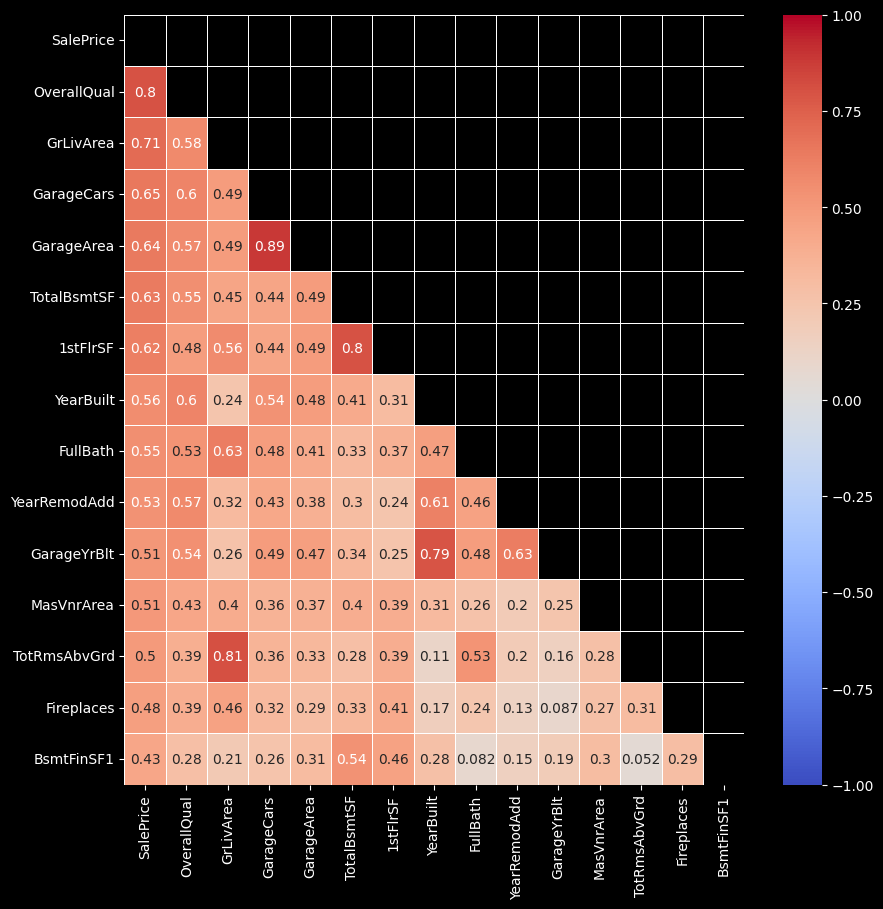

In [ ]:
# ▶ corr() 활용, numerical value 상관관계 확인
fig = plt.figure(figsize=(10,10))
df_num = df[n_features].corr()
sns.heatmap(df_num, vmin = -1, vmax = +1, annot = True, cmap = 'coolwarm', linewidths=.5, mask=np.triu(df_num.corr()));

<Axes: xlabel='GrLivArea', ylabel='SalePrice'>

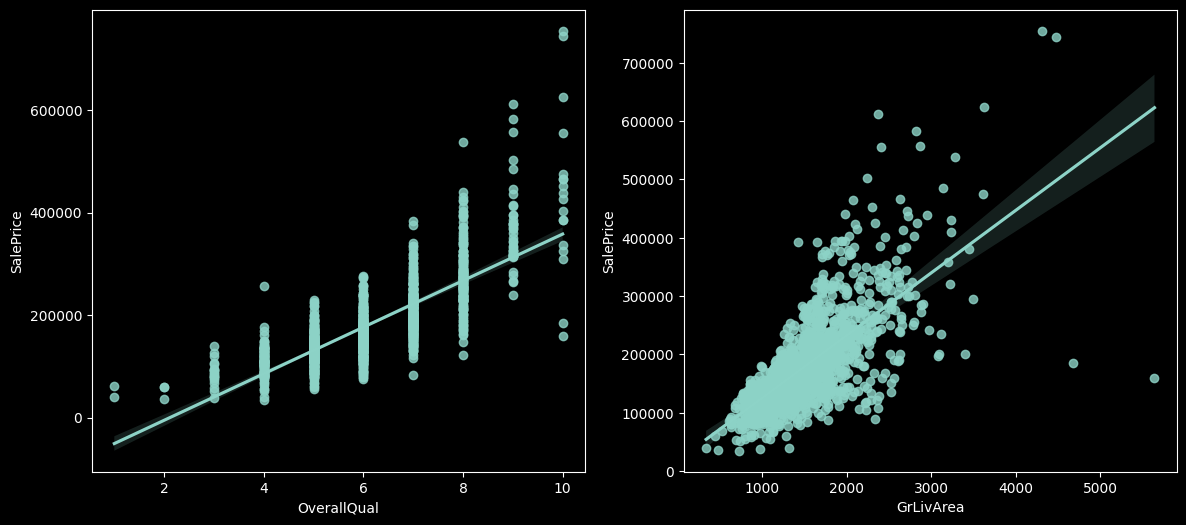

In [ ]:
# corr top 2개 확인
figure, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(14,6)

sns.regplot(x=train_df['OverallQual'], y=train_df['SalePrice'],ax=ax1)
sns.regplot(x=train_df['GrLivArea'], y=train_df['SalePrice'],ax=ax2)

In [ ]:
# OverallQual 점수별 SalePrice 평균
tmp_df = train_df.groupby('OverallQual')['SalePrice'].mean()
tmp_df

OverallQual
1      50150.000000
2      51770.333333
3      87473.750000
4     108420.655172
5     133523.347607
6     161603.034759
7     207716.423197
8     274735.535714
9     367513.023256
10    438588.388889
Name: SalePrice, dtype: float64

In [ ]:
# OverallQual 점수별 SalePrice 분산
tmp_df = train_df.groupby('OverallQual')['SalePrice'].std()
tmp_df

OverallQual
1      15344.217152
2      14254.200796
3      24688.567399
4      29022.003886
5      27107.330927
6      36090.182933
7      44466.259414
8      63898.902253
9      81278.174849
10    159785.491058
Name: SalePrice, dtype: float64

In [ ]:
# 상관계수 중 target 변수인 SalePrice 열(col)만 가져오기
tmp_corr_y = pd.DataFrame(df_num['OverallQual'].sort_values(ascending=False))
tmp_corr_y

,OverallQual
OverallQual,1.000000
SalePrice,0.800888
GarageCars,0.600682
YearBuilt,0.597554
GrLivArea,0.575126
YearRemodAdd,0.571532
GarageArea,0.565065
TotalBsmtSF,0.549087
GarageYrBlt,0.544247
FullBath,0.528483


In [ ]:
# 오른쪽 아래 Outlier 제거
train_df=train_df.drop(train_df[(train_df['GrLivArea']>4000) & (train_df['SalePrice']<300000)].index)

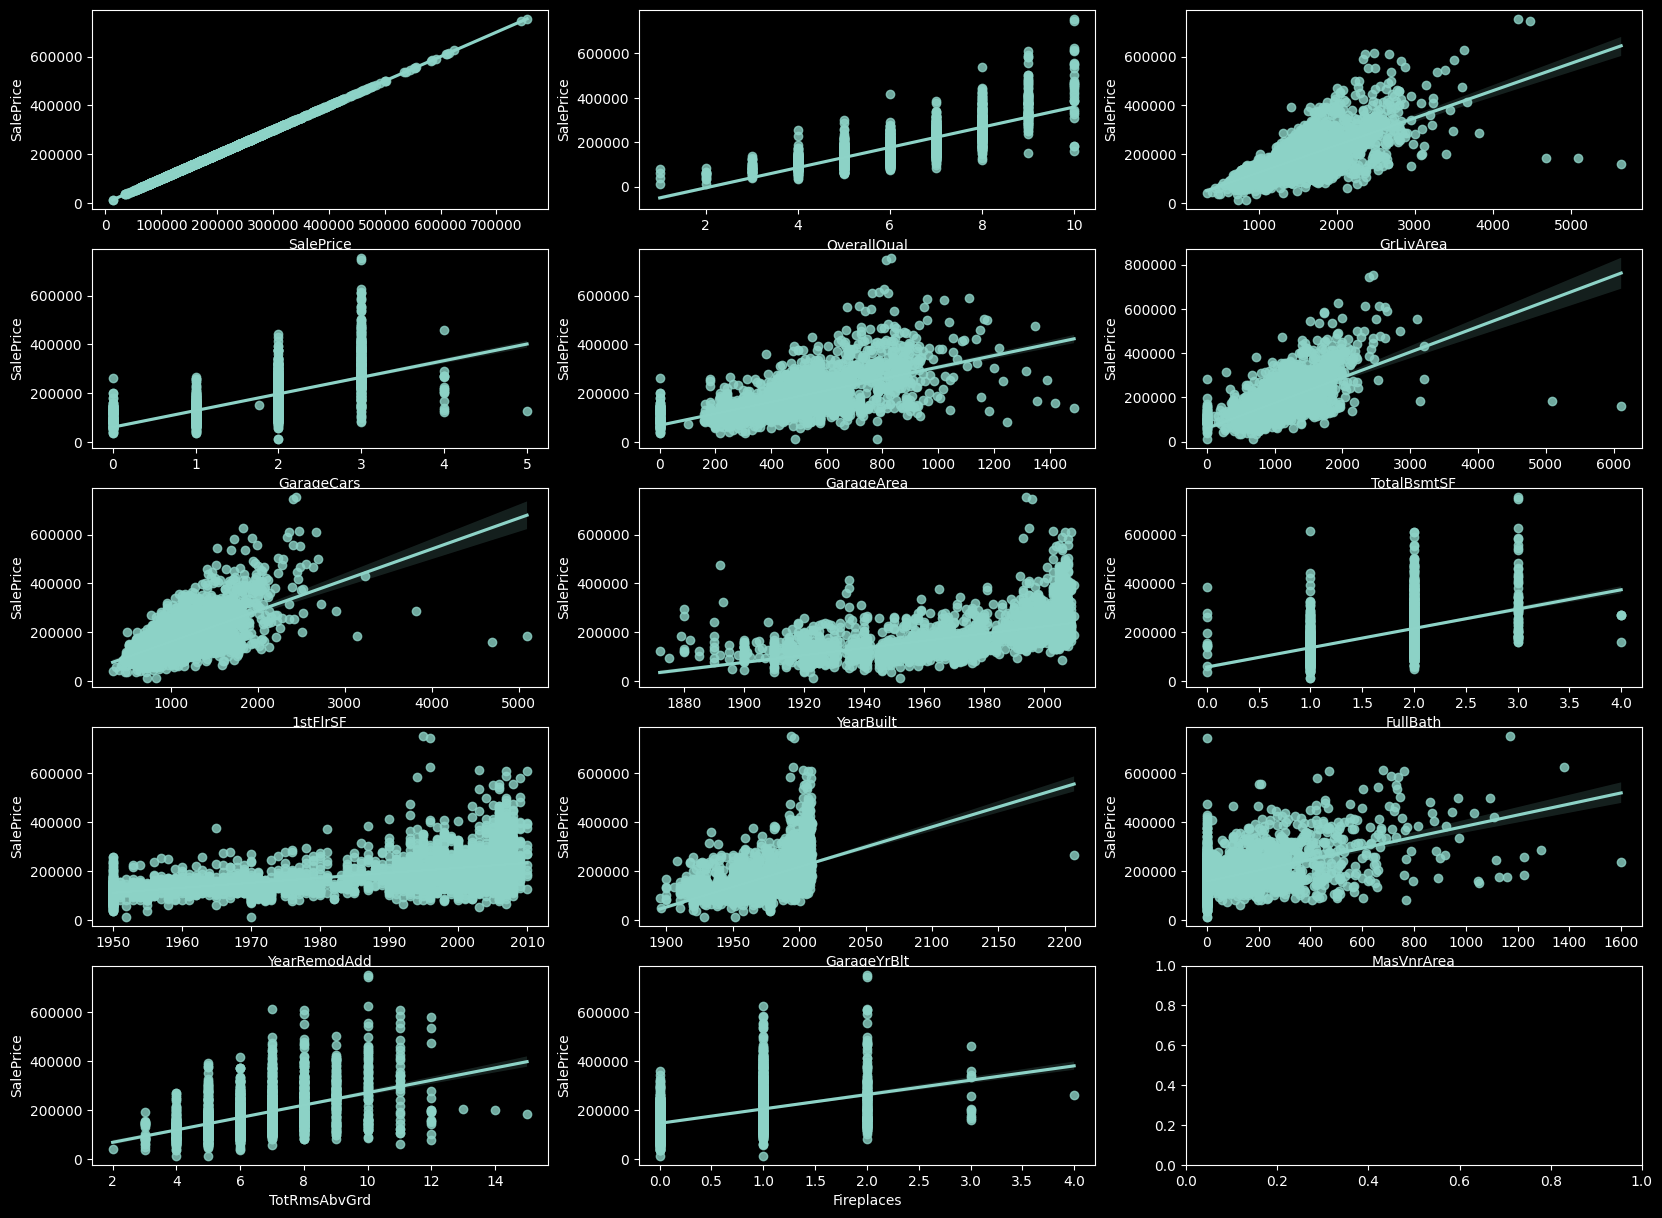

In [ ]:
# 선택한 숫자형 데이터 분포 확인

fig, ax = plt.subplots(round(len(n_features) / 3), 3, figsize = (20, 15))

for i, ax in enumerate(fig.axes):
    if i < len(n_features) - 1:
        sns.regplot(x=n_features[i],y='SalePrice', data=df[n_features], ax=ax)

In [ ]:
# 타겟 데이터 로그 처리 및 선정한 숫자형 데이터 분리
y_train=df['SalePrice']
y_train=np.log(y_train+1)
all_data = df
data = train_df
print(df.shape)

(2919, 81)


In [ ]:
# 결측치 처리
for col in ('PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType', 'MSSubClass'):
    all_data[col] = all_data[col].fillna('None')

for col in ('GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea','LotFrontage'):
    all_data[col] = all_data[col].fillna(0)

for col in ('MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType', 'Functional', 'Utilities'):
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

print(f"Total count of missing values in all_data : {all_data.isnull().sum().sum()}")

Total count of missing values in all_data : 0


In [ ]:
# 전체 데이터 결측치 재확인
cols=list(all_data)
for col in list(all_data):
    if (all_data[col].isnull().sum())==0:
        cols.remove(col)
    else:
        pass
print(len(cols))

0


**┗ 가설 수립 및 검증**  
---


<Axes: ylabel='SalePrice'>

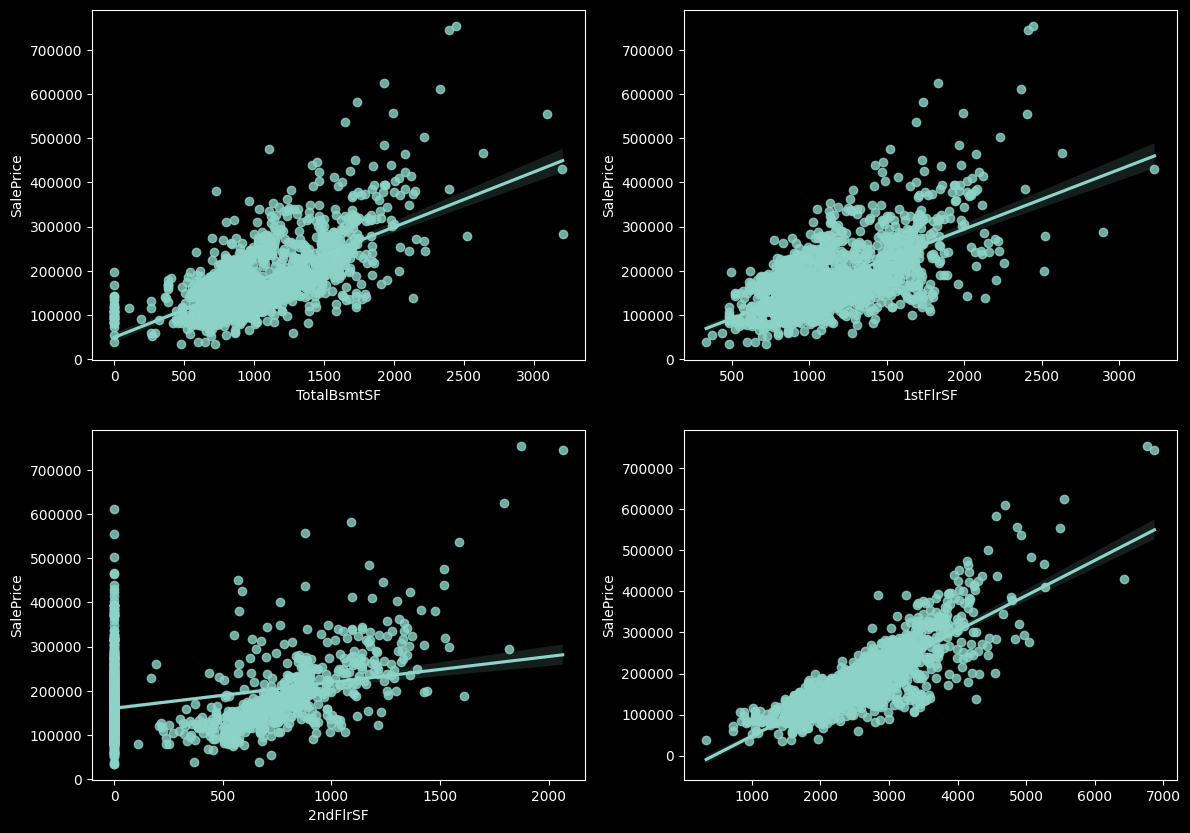

In [ ]:
# ▶ (1) 총 가용 면적(Total SF Available)
figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
figure.set_size_inches(14,10)
sns.regplot(x=data['TotalBsmtSF'], y=data['SalePrice'], ax=ax1)
sns.regplot(x=data['1stFlrSF'], y=data['SalePrice'], ax=ax2)
sns.regplot(x=data['2ndFlrSF'], y=data['SalePrice'], ax=ax3)
sns.regplot(x=(data['TotalBsmtSF'] + data['1stFlrSF'] + data['2ndFlrSF']), y=data['SalePrice'], ax=ax4)

In [ ]:
# 총가용 면적 데이터 추가
all_data['TotalSF']=all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']
# all_data['No2ndFlr']=(all_data['2ndFlrSF']==0)
# all_data['NoBsmt']=(all_data['TotalBsmtSF']==0)

<Axes: ylabel='SalePrice'>

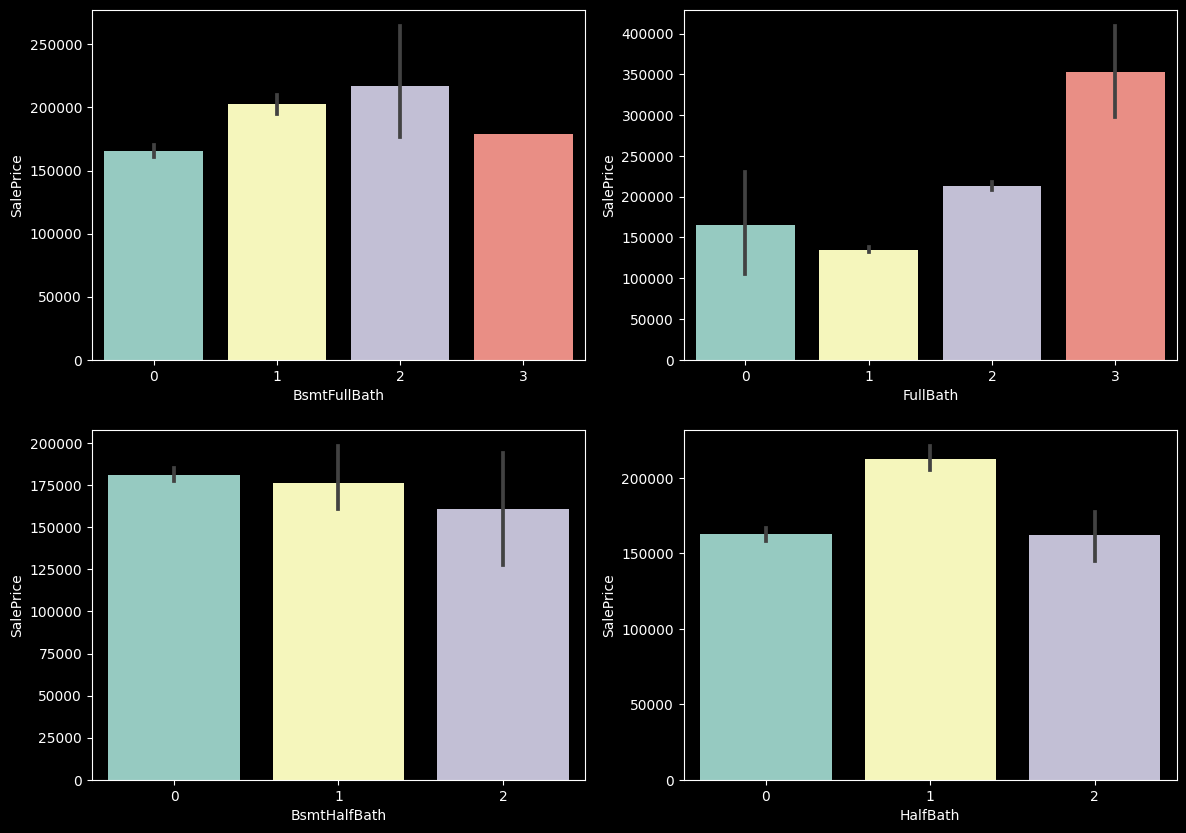

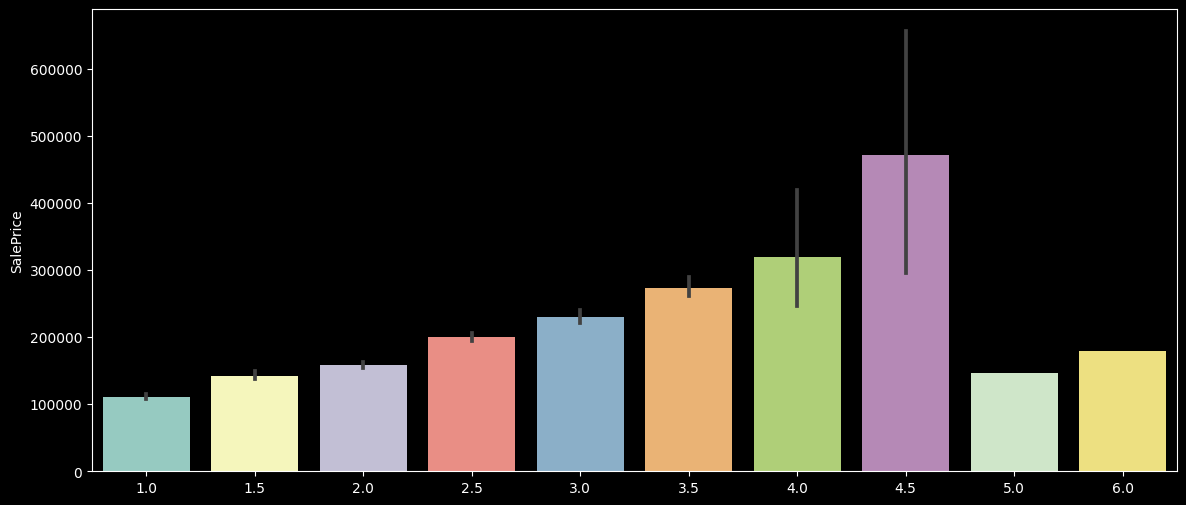

In [ ]:
# ▶ (2) 총 욕실 수(Bath)
figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
figure.set_size_inches(14,10)
sns.barplot(x=data['BsmtFullBath'], y=data['SalePrice'], ax=ax1)
sns.barplot(x=data['FullBath'], y=data['SalePrice'], ax=ax2)
sns.barplot(x=data['BsmtHalfBath'], y=data['SalePrice'], ax=ax3)
sns.barplot(x=data['HalfBath'], y=data['SalePrice'], ax=ax4)

figure, (ax5) = plt.subplots(nrows=1, ncols=1)
figure.set_size_inches(14,6)
sns.barplot(x=(data['BsmtFullBath'] + data['FullBath'] + (data['BsmtHalfBath']/2) + (data['HalfBath']/2)), y=data['SalePrice'], ax=ax5)

In [ ]:
# 욕실수가 많을수록 SalePrice 증가하는 경향을 보임
# 욕실수가 5개, 6개 편차가 없음 > 데이터가 하나씩만 존재 > Outlier로 판단
all_data['TotalBath']=all_data['BsmtFullBath'] + all_data['FullBath'] + (all_data['BsmtHalfBath']/2) + (all_data['HalfBath']/2)

In [ ]:
tmp_bath_df = data[['BsmtFullBath', 'FullBath', 'BsmtHalfBath', 'HalfBath','SalePrice']]
tmp_bath_df['TotalBath'] = tmp_bath_df['BsmtFullBath'] + tmp_bath_df['FullBath'] +tmp_bath_df['BsmtHalfBath'] + tmp_bath_df['HalfBath']
tmp_bath_df.groupby('TotalBath').mean()

,BsmtFullBath,FullBath,BsmtHalfBath,HalfBath,SalePrice
TotalBath,,,,,
1,0.004386,0.995614,0.000000,0.000000,110869.671053
2,0.370629,1.403846,0.050699,0.174825,154276.674825
3,0.501048,1.834382,0.071279,0.593291,212191.203354
4,0.906977,2.034884,0.104651,0.953488,263504.354651
5,0.666667,3.000000,0.333333,1.000000,535466.666667
6,2.000000,2.333333,0.333333,1.333333,174966.666667


<Axes: ylabel='SalePrice'>

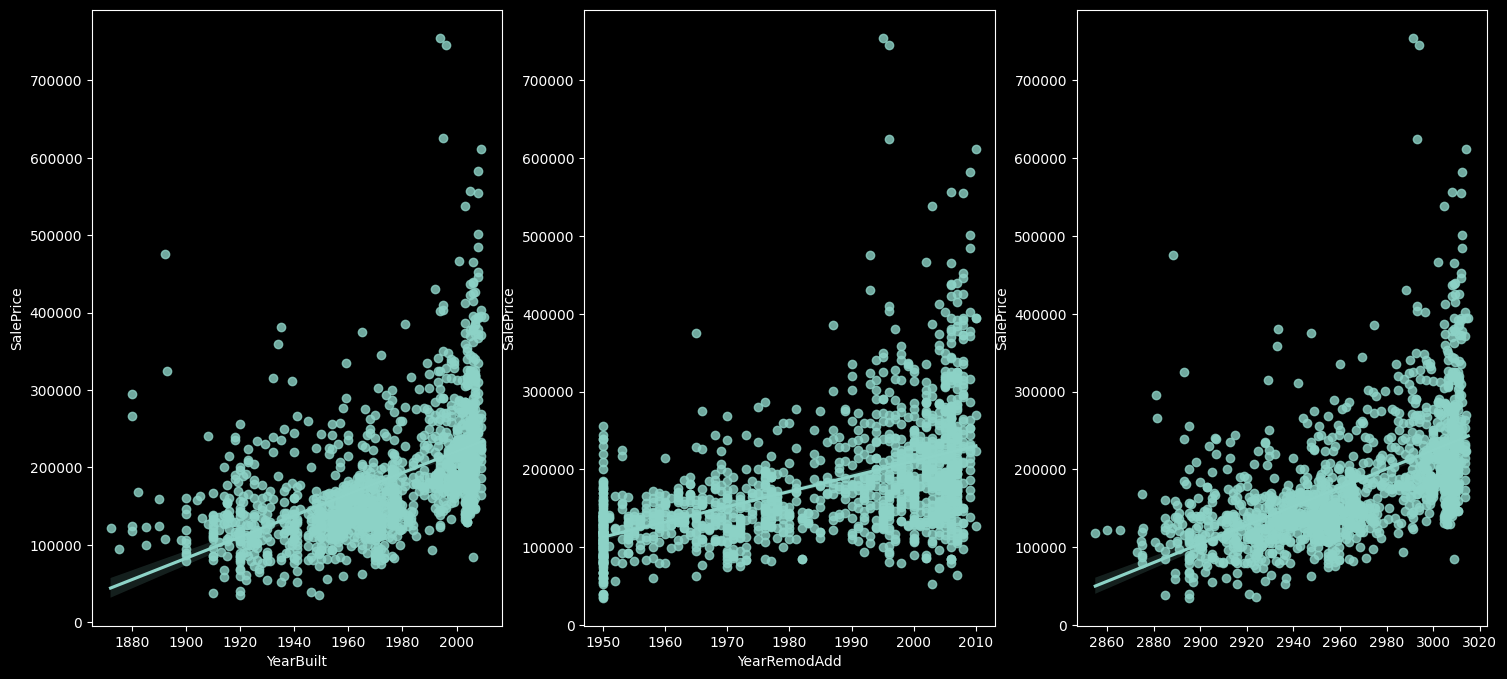

In [ ]:
# ▶ (3) 건축연도 + 리모델링 연도(Year Built and Remodeled)
figure, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3)
figure.set_size_inches(18,8)
sns.regplot(x=data['YearBuilt'], y=data['SalePrice'], ax=ax1)
sns.regplot(x=data['YearRemodAdd'], y=data['SalePrice'], ax=ax2)
sns.regplot(x=(data['YearBuilt']+ data['YearRemodAdd']/2) , y=data['SalePrice'], ax=ax3) #'/2' for graph scaling

In [ ]:
# 건축연도가 오래 되었어도, 최근에 리모델링을 하면 SalePrice 높음(graph 3)
all_data['YrBltAndRemod']=all_data['YearBuilt']+all_data['YearRemodAdd']

In [ ]:
year_df = all_data[['YrBltAndRemod','SalePrice']]
year_df.to_csv('year_data.csv',index=False)

In [ ]:
# 지하실 점수(Bsmt)
Basement = ['BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'BsmtUnfSF', 'TotalBsmtSF']
Bsmt=all_data[Basement]

In [ ]:
# 지하실 점수 숫자형 점수로 변환
Bsmt=Bsmt.replace(to_replace='Po', value=1)
Bsmt=Bsmt.replace(to_replace='Fa', value=2)
Bsmt=Bsmt.replace(to_replace='TA', value=3)
Bsmt=Bsmt.replace(to_replace='Gd', value=4)
Bsmt=Bsmt.replace(to_replace='Ex', value=5)
Bsmt=Bsmt.replace(to_replace='None', value=0)

Bsmt=Bsmt.replace(to_replace='No', value=1)
Bsmt=Bsmt.replace(to_replace='Mn', value=2)
Bsmt=Bsmt.replace(to_replace='Av', value=3)
Bsmt=Bsmt.replace(to_replace='Gd', value=4)

Bsmt=Bsmt.replace(to_replace='Unf', value=1)
Bsmt=Bsmt.replace(to_replace='LwQ', value=2)
Bsmt=Bsmt.replace(to_replace='Rec', value=3)
Bsmt=Bsmt.replace(to_replace='BLQ', value=4)
Bsmt=Bsmt.replace(to_replace='ALQ', value=5)
Bsmt=Bsmt.replace(to_replace='GLQ', value=6)

In [ ]:
# 'BsmtFinScore' 은 지하실의 완성도 점수, 'BsmtScore' 은 지하실의 종합 점수, 'BsmtDNF' 는 지하실의 미완성 여부를 나타내는 변수

Bsmt['BsmtScore']= Bsmt['BsmtQual']  * Bsmt['BsmtCond'] * Bsmt['TotalBsmtSF']
all_data['BsmtScore']=Bsmt['BsmtScore']

Bsmt['BsmtFin'] = (Bsmt['BsmtFinSF1'] * Bsmt['BsmtFinType1']) + (Bsmt['BsmtFinSF2'] * Bsmt['BsmtFinType2'])
all_data['BsmtFinScore']=Bsmt['BsmtFin']
# all_data['BsmtDNF']=(all_data['BsmtFinScore']==0)

In [ ]:
# 토지 점수(Lot)
lot=['LotFrontage', 'LotArea','LotConfig','LotShape']
Lot=all_data[lot]

Lot['LotScore'] = np.log((Lot['LotFrontage'] * Lot['LotArea'])+1)

all_data['LotScore']=Lot['LotScore']

In [ ]:
# 차고 점수 (Garage)
garage=['GarageArea','GarageCars','GarageCond','GarageFinish','GarageQual','GarageType','GarageYrBlt']
Garage=all_data[garage]
# all_data['NoGarage']=(all_data['GarageArea']==0)

In [ ]:
# 차고 점수 숫자형 변수로 변환

Garage=Garage.replace(to_replace='Po', value=1)
Garage=Garage.replace(to_replace='Fa', value=2)
Garage=Garage.replace(to_replace='TA', value=3)
Garage=Garage.replace(to_replace='Gd', value=4)
Garage=Garage.replace(to_replace='Ex', value=5)
Garage=Garage.replace(to_replace='None', value=0)

Garage=Garage.replace(to_replace='Unf', value=1)
Garage=Garage.replace(to_replace='RFn', value=2)
Garage=Garage.replace(to_replace='Fin', value=3)

Garage=Garage.replace(to_replace='CarPort', value=1)
Garage=Garage.replace(to_replace='Basment', value=4)
Garage=Garage.replace(to_replace='Detchd', value=2)
Garage=Garage.replace(to_replace='2Types', value=3)
Garage=Garage.replace(to_replace='Basement', value=5)
Garage=Garage.replace(to_replace='Attchd', value=6)
Garage=Garage.replace(to_replace='BuiltIn', value=7)
Garage['GarageScore']=(Garage['GarageArea']) * (Garage['GarageCars']) * (Garage['GarageFinish']) * (Garage['GarageQual']) * (Garage['GarageType'])
all_data['GarageScore']=Garage['GarageScore']

<Axes: xlabel='GarageSpace', ylabel='SalePrice'>

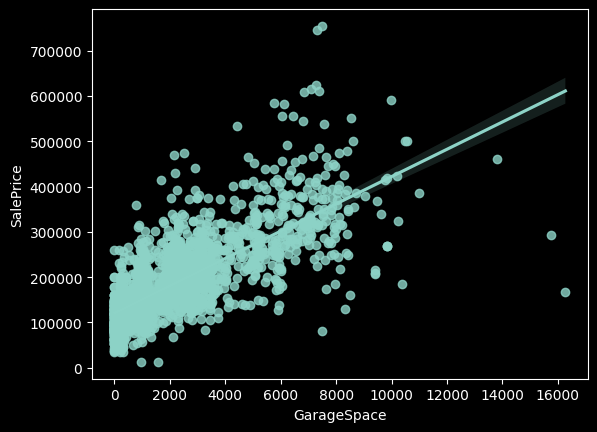

In [ ]:
tmp_garage_df = all_data[['GarageCars','GarageArea','GarageYrBlt','GarageFinish','SalePrice']]

tmp_garage_df.replace(to_replace='None', value=0, inplace=True)
tmp_garage_df.replace(to_replace='Unf', value=1, inplace=True)
tmp_garage_df.replace(to_replace='RFn', value=2, inplace=True)
tmp_garage_df.replace(to_replace='Fin', value=3, inplace=True)

tmp_garage_df['GarageSpace'] = (tmp_garage_df['GarageCars']*tmp_garage_df['GarageArea']*tmp_garage_df['GarageFinish'])

figure.set_size_inches(18,8)
sns.regplot(x=tmp_garage_df['GarageSpace'], y=tmp_garage_df['SalePrice'])

In [ ]:
tmp_garage_df.corr()

,GarageCars,GarageArea,GarageYrBlt,GarageFinish,SalePrice,GarageSpace
GarageCars,1.000000,0.889700,0.489430,0.576256,0.649497,0.793344
GarageArea,0.889700,1.000000,0.473504,0.510975,0.641731,0.796730
GarageYrBlt,0.489430,0.473504,1.000000,0.466291,0.510749,0.549416
GarageFinish,0.576256,0.510975,0.466291,1.000000,0.550397,0.706120
SalePrice,0.649497,0.641731,0.510749,0.550397,1.000000,0.757054
GarageSpace,0.793344,0.796730,0.549416,0.706120,0.757054,1.000000


In [ ]:
tmp_garage_df.to_csv('Garage_data.csv', index=False)

<Axes: xlabel='LotScore', ylabel='SalePrice'>

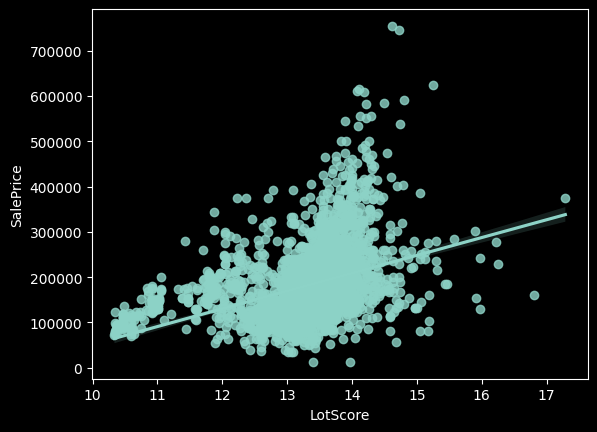

In [ ]:
figure.set_size_inches(18,8)
sns.regplot(x=all_data['LotScore'], y=all_data['SalePrice'])

categorical_list : ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
numerical_list : ['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageA

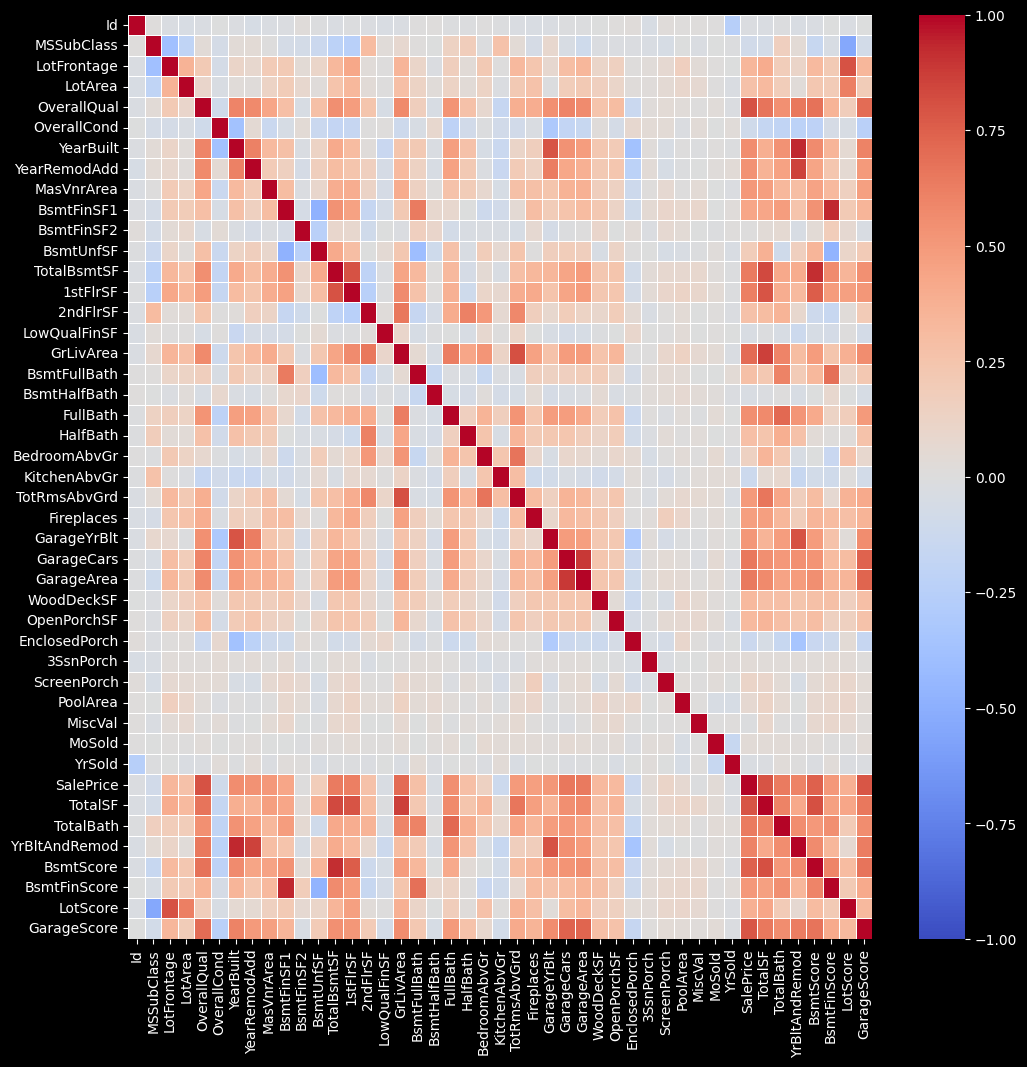

In [ ]:
# ▶ corr() 활용, numerical value 추가된 데이터 상관관계 확인
# ▶ numeric, categorical value 나누기
numerical_list=[]
categorical_list=[]

for i in df.columns :
  if all_data[i].dtypes == 'O' :
    categorical_list.append(i)
  else :
    numerical_list.append(i)

print("categorical_list :", categorical_list)
print("numerical_list :", numerical_list)

fig = plt.figure(figsize=(12,12))
all_df_num = all_data[numerical_list].corr()
sns.heatmap(all_df_num, vmin = -1, vmax = +1, annot = False, cmap = 'coolwarm', linewidths=.5);

In [ ]:
# 상관계수 중 target 변수인 SalePrice 열(col)만 가져오기
all_data_corr_y = pd.DataFrame(all_df_num['SalePrice'].sort_values(ascending=False))
all_data_corr_y

,SalePrice
SalePrice,1.000000
OverallQual,0.800888
TotalSF,0.794240
GarageScore,0.782829
BsmtScore,0.748600
GrLivArea,0.708096
GarageCars,0.649497
GarageArea,0.641731
TotalBath,0.636743
TotalBsmtSF,0.633055


In [ ]:
# corr 0.4 초과 데이터
n_features = list(all_data_corr_y[abs(all_data_corr_y['SalePrice']) > 0.4].index)
print(n_features)

['SalePrice', 'OverallQual', 'TotalSF', 'GarageScore', 'BsmtScore', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBath', 'TotalBsmtSF', '1stFlrSF', 'YrBltAndRemod', 'YearBuilt', 'FullBath', 'YearRemodAdd', 'GarageYrBlt', 'MasVnrArea', 'BsmtFinScore', 'TotRmsAbvGrd', 'Fireplaces', 'BsmtFinSF1']


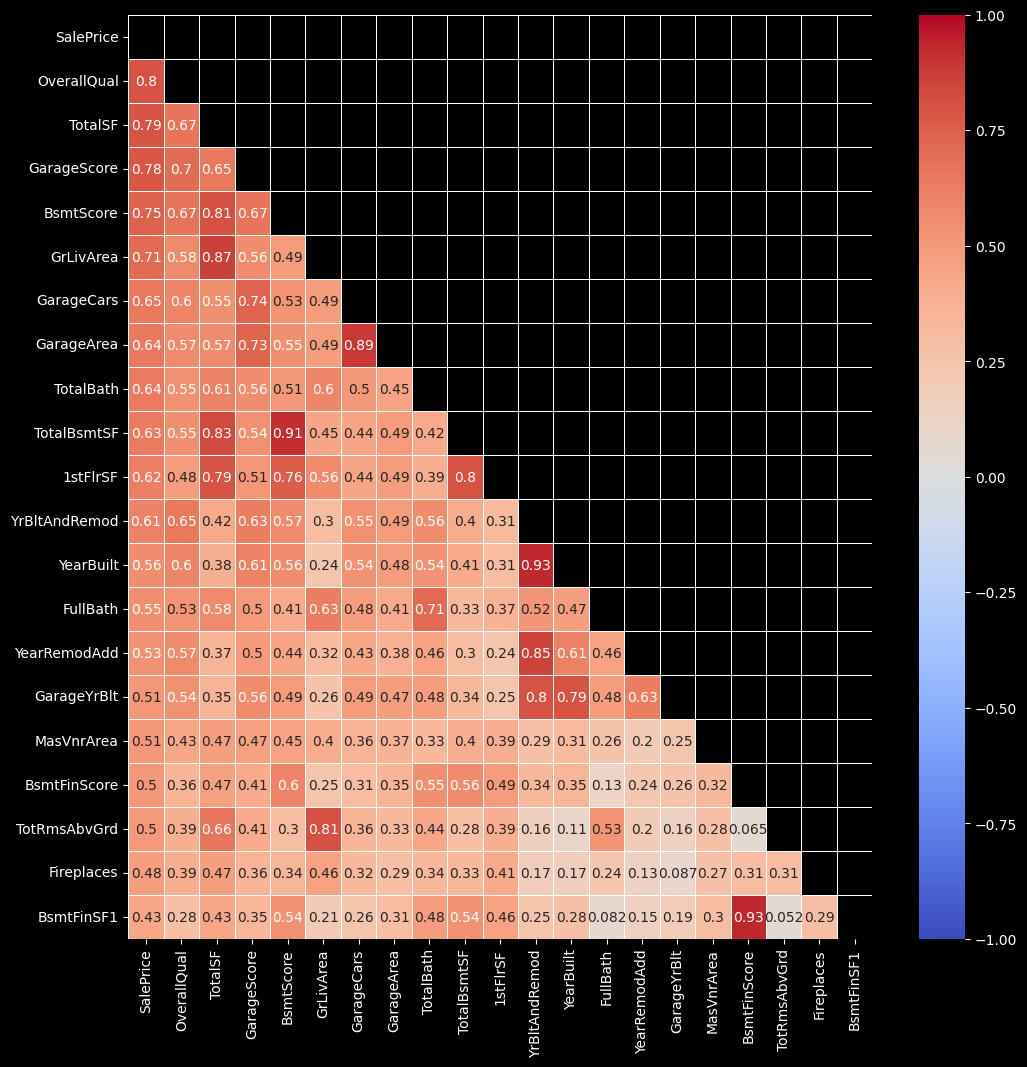

In [ ]:
# ▶ corr() 활용, numerical value 상관관계 확인
fig = plt.figure(figsize=(12,12))
df_num = all_data[n_features].corr()
sns.heatmap(df_num, vmin = -1, vmax = +1, annot = True, cmap = 'coolwarm', linewidths=.5, mask=np.triu(df_num.corr()));

<Axes: xlabel='PoolQC', ylabel='SalePrice'>

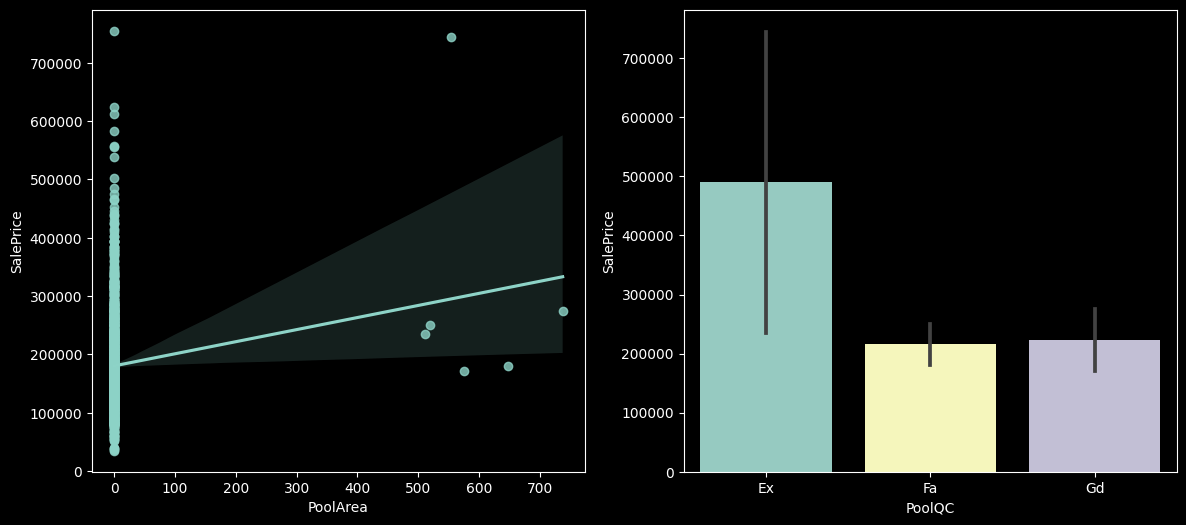

In [ ]:
# 수영장 있는 집 확인
figure, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(14,6)
sns.regplot(data=data, x='PoolArea', y='SalePrice', ax=ax1)
sns.barplot(data=data, x='PoolQC', y='SalePrice', ax=ax2)

In [ ]:
# 수영장이 있는 집은 매우 적으므로 삭제
all_data=all_data.drop(columns=['PoolArea','PoolQC'])
tmp = ['PoolArea','PoolQC']

# 범주형 데이터 리스트 col 삭제
for i in tmp:
  if i in categorical_list:
    categorical_list.remove(i)

<Axes: xlabel='MiscFeature', ylabel='SalePrice'>

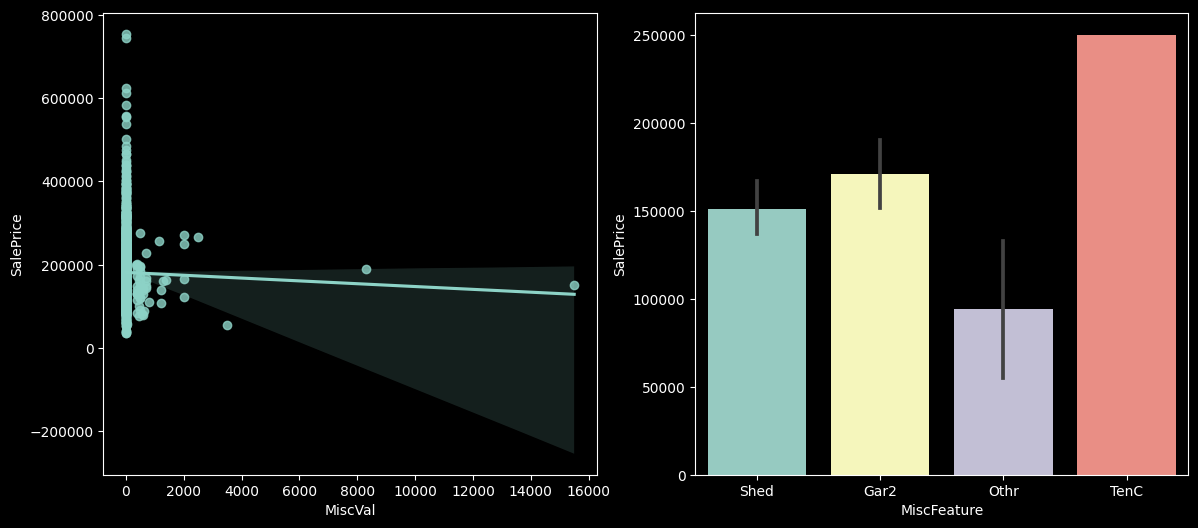

In [ ]:
figure, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(14,6)
sns.regplot(data=data, x='MiscVal', y='SalePrice', ax=ax1)
sns.barplot(data=data, x='MiscFeature', y='SalePrice', ax=ax2)

In [ ]:
# 테니스 코트가 있는 집의 데이터가 매우 적으므로 삭제
all_data=all_data.drop(columns=['MiscVal','MiscFeature'])

tmp = ['MiscVal','MiscFeature']

# 범주형 데이터 리스트 col 삭제
for i in tmp:
  if i in categorical_list:
    categorical_list.remove(i)

<Axes: xlabel='WoodDeckSF', ylabel='SalePrice'>

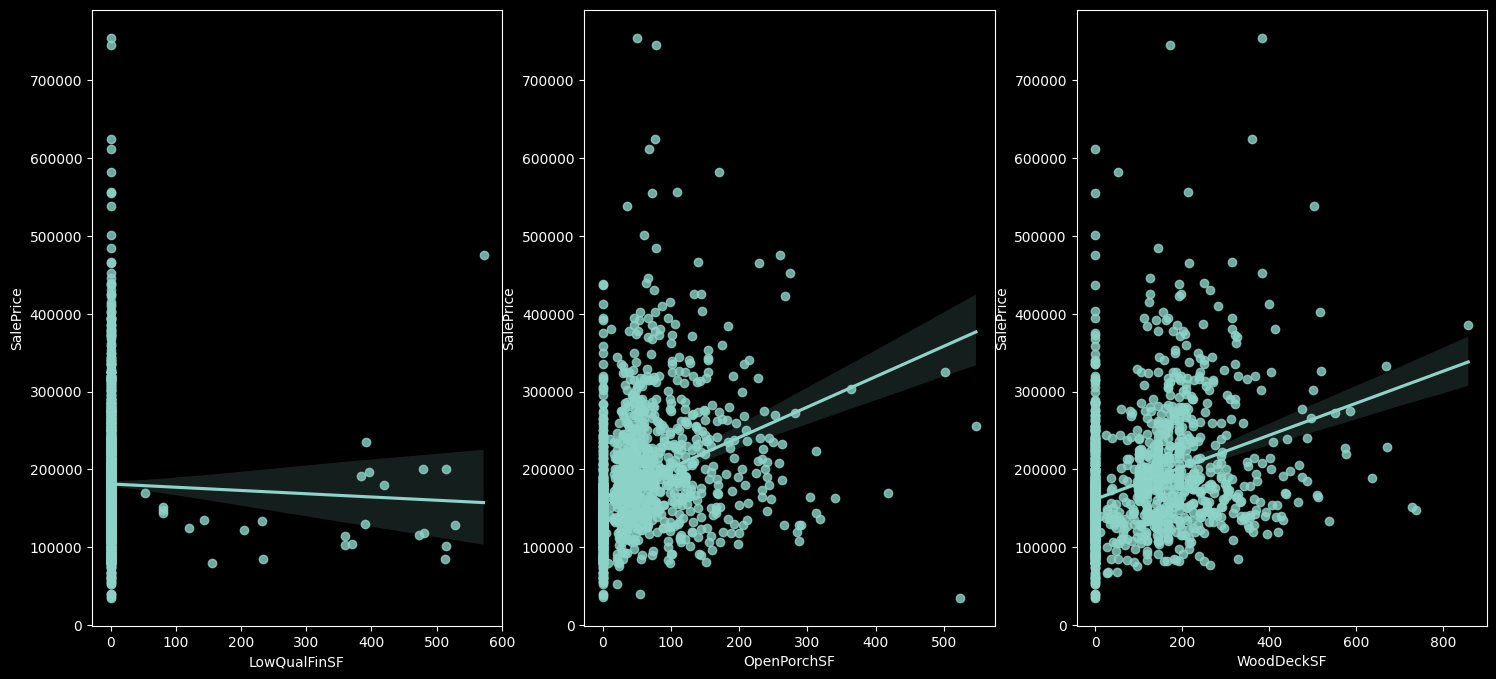

In [ ]:
# 수정된 결측치가 많은 경우
figure, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3)
figure.set_size_inches(18,8)

sns.regplot(data=data, x='LowQualFinSF', y='SalePrice', ax=ax1)
sns.regplot(data=data, x='OpenPorchSF', y='SalePrice', ax=ax2)
sns.regplot(data=data, x='WoodDeckSF', y='SalePrice', ax=ax3)

In [ ]:
# 0인 값만 분리
# all_data['NoLowQual']=(all_data['LowQualFinSF']==0)
# all_data['NoOpenPorch']=(all_data['OpenPorchSF']==0)
# all_data['NoWoodDeck']=(all_data['WoodDeckSF']==0)

In [ ]:
# 범주형 변수 확인
list_of_df = []

for var in categorical_list :
  temp = data.groupby(var)['SalePrice'].agg(['count', 'mean']).sort_values(by=['mean'], ascending=False)
  temp['lift'] = temp['mean'] / data['SalePrice'].mean()
  temp['ratio'] = round((temp['count'] / len(df))*100,2)
  print(temp)
  print('______________________________________________________________')

          count           mean      lift  ratio
MSZoning                                       
FV           65  214014.061538  1.182837   2.23
RL         1149  191037.422977  1.055847  39.36
RH           16  131558.375000  0.727111   0.55
RM          218  126316.830275  0.698142   7.47
C (all)      10   74528.000000  0.411910   0.34
______________________________________________________________
        count           mean      lift  ratio
Street                                       
Pave     1452  181142.598485  1.001159  49.74
Grvl        6  130190.500000  0.719551   0.21
______________________________________________________________
       count           mean      lift  ratio
Alley                                       
Pave      41  168000.585366  0.928524   1.40
Grvl      50  122219.080000  0.675494   1.71
______________________________________________________________
          count           mean      lift  ratio
LotShape                                       
IR2          41

In [ ]:
# ▶ 의미없는 변수 삭제 결정,
categorical_list.remove('Street')
categorical_list.remove('Utilities')
categorical_list.remove('Functional')
categorical_list.remove('LandSlope')

all_data=all_data.drop(columns=['Street','Utilities', 'Functional', 'LandSlope'])

print(categorical_list)
print(len(categorical_list))

['MSZoning', 'Alley', 'LotShape', 'LandContour', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'Fence', 'SaleType', 'SaleCondition']
37


In [ ]:
# non_numeric=all_data.select_dtypes(np.object)
# c_featrues = categorical_list
# categorical_columns = []
# categricla_dims = {}

# def onehot(col_list):
#     global all_data
#     while len(col_list) !=0:
#         col=col_list.pop(0)
#         data_encoded=pd.get_dummies(all_data[col], prefix=col)
#         all_data=pd.concat([all_data, data_encoded], axis=1)
#         all_data=all_data.drop(columns=col)

#     print(all_data.shape)

# onehot(list(non_numeric))

In [ ]:
# 수치형 변수 Right Skewed log 처리
def log_transform(col_list):
    for col in col_list:
        if all_data[col].skew() > 0.5:
            all_data[col]=np.log(all_data[col]+1)
        else:
            pass
    print(all_data.shape)

log_transform(n_features)

(2919, 80)


<Axes: xlabel='SalePrice', ylabel='Density'>

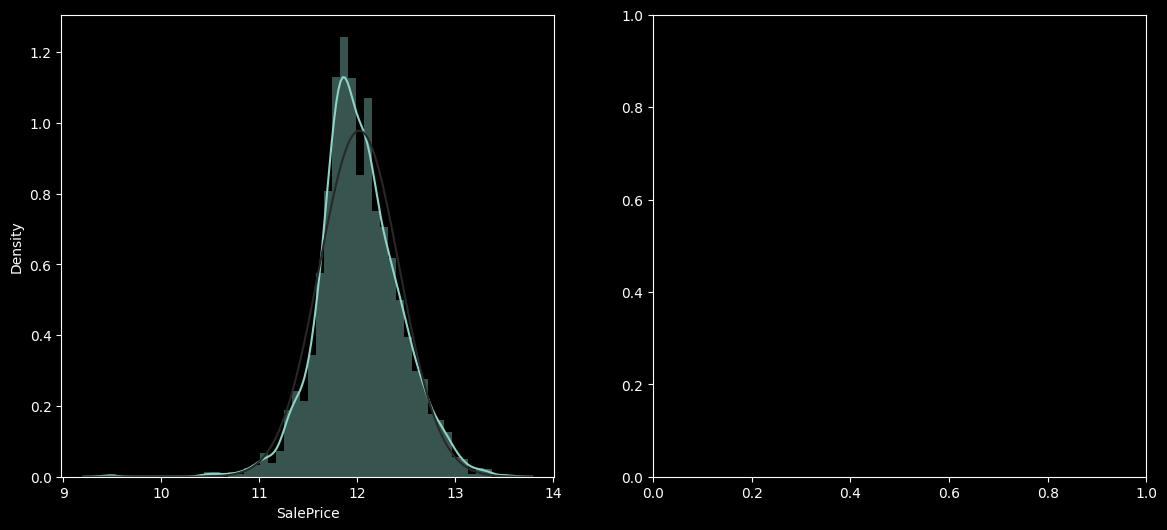

In [ ]:
# 타겟 데이터 분포 재확인
figure, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(14,6)
sns.distplot(all_data['SalePrice'], fit=norm, ax=ax1)

In [ ]:
# 최종 features 리스트
features_list = n_features + categorical_list

# 최종 데이터
df = all_data[features_list]
print("학습에 사용할 feature 개수: ", len(features_list), "개")

학습에 사용할 feature 개수:  58 개


## **🥇Session 3**  
**┗ TabNet 활용 소득 예측**  
---

In [ ]:
# 범주형 변수 LabelEncoding

from sklearn.preprocessing import LabelEncoder

c_features = categorical_list
categorical_columns = []
categorical_dims =  {}

for col in c_features:
    print(col, df[col].nunique())
    l_enc = LabelEncoder()
    df[col] = l_enc.fit_transform(df[col].values)
    categorical_columns.append(col)
    categorical_dims[col] = len(l_enc.classes_)

MSZoning 6
Alley 3
LotShape 4
LandContour 4
LotConfig 5
Neighborhood 25
Condition1 9
Condition2 8
BldgType 5
HouseStyle 8
RoofStyle 6
RoofMatl 8
Exterior1st 16
Exterior2nd 17
MasVnrType 4
ExterQual 4
ExterCond 5
Foundation 6
BsmtQual 5
BsmtCond 5
BsmtExposure 5
BsmtFinType1 7
BsmtFinType2 7
Heating 6
HeatingQC 5
CentralAir 2
Electrical 6
KitchenQual 5
FireplaceQu 6
GarageType 7
GarageFinish 4
GarageQual 6
GarageCond 6
PavedDrive 3
Fence 5
SaleType 10
SaleCondition 6


### · 모델링을 위한 데이터 준비
---
* 모델링을 수행하기 위해 Feature와 예측하고자하는 값인 Y로 데이터를 나눔
* 학습과 예측을 위한 Train / Test set 분할

In [ ]:
# 타켓 설정
target = 'SalePrice'
if "Set" not in df.columns:
    df["Set"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(df.shape[0],))

train_indices = df[df['Set']=="train"].index
valid_indices = df[df['Set']=="valid"].index
test_indices = df[df['Set']=="test"].index

In [ ]:
# ▶ Define categorical features for categorical embeddings
# ▶ TabNet을 활용하기 위해서는 카테고리 변수와 dim을 전달해야 함
unused_feat = ['Set']
features = [ col for col in df.columns if col not in unused_feat+[target]]
cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]
cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

### · 모델 학습 및 평가
---
* TabNet 모델 학습 및 평가

In [ ]:
# ▶ train, valid, test data 분할
X_train = df[features].values[train_indices]
y_train = df[target].values[train_indices].reshape(-1, 1)

X_valid = df[features].values[valid_indices]
y_valid = df[target].values[valid_indices].reshape(-1, 1)

X_test = df[features].values[test_indices]
y_test = df[target].values[test_indices].reshape(-1, 1)

In [ ]:
X_test.shape

(329, 57)

In [ ]:
import torch
# ▶ TabNet을 활용하기 위해서는 카테고리 변수와 dim을 전달해야 함
# ▶ cat_emb_dim : List of embeddings size for each categorical features.
from pytorch_tabnet.tab_model import TabNetRegressor
reg = TabNetRegressor(cat_dims=cat_dims,
                      cat_emb_dim=1,
                      cat_idxs=cat_idxs,
                      optimizer_fn=torch.optim.Adam,
                      optimizer_params=dict(lr=1e-3),
                      scheduler_params={"step_size":50, "gamma":0.9},
                      scheduler_fn=torch.optim.lr_scheduler.StepLR,
                      verbose=20)

In [ ]:
# ▶ 모델 학습
max_epochs = 300
model = reg.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    eval_metric=['mse', 'mae', 'rmse', 'rmsle'],
    max_epochs=max_epochs,
    drop_last=True,
    patience=200
)

epoch 0  | loss: 144.92648| train_mse: 54206.11216| train_mae: 211.0115| train_rmse: 232.82206| train_rmsle: 2.93819 | valid_mse: 54868.56391| valid_mae: 213.46039| valid_rmse: 234.2404| valid_rmsle: 2.94743 |  0:00:00s
epoch 20 | loss: 122.21133| train_mse: 537.8899| train_mae: 15.44708| train_rmse: 23.19245| train_rmsle: 2.32285 | valid_mse: 449.07816| valid_mae: 14.94027| valid_rmse: 21.19146| valid_rmsle: 2.36978 |  0:00:05s
epoch 40 | loss: 100.89579| train_mse: 826.99799| train_mae: 17.99196| train_rmse: 28.75757| train_rmsle: 1.99556 | valid_mse: 785.36203| valid_mae: 17.52364| valid_rmse: 28.02431| valid_rmsle: 1.96913 |  0:00:12s
epoch 60 | loss: 79.78175| train_mse: 391.04164| train_mae: 12.65941| train_rmse: 19.77477| train_rmsle: 1.51521 | valid_mse: 438.70921| valid_mae: 12.5605 | valid_rmse: 20.94539| valid_rmsle: 1.47106 |  0:00:18s
epoch 80 | loss: 59.69784| train_mse: 246.74799| train_mae: 10.32554| train_rmse: 15.70821| train_rmsle: 1.01664 | valid_mse: 208.26634| val

mse


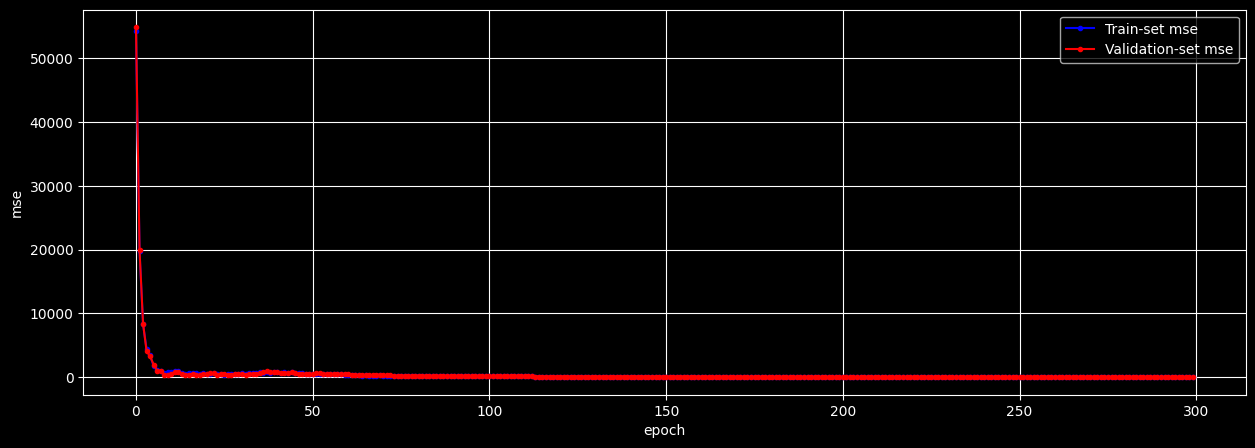

mae


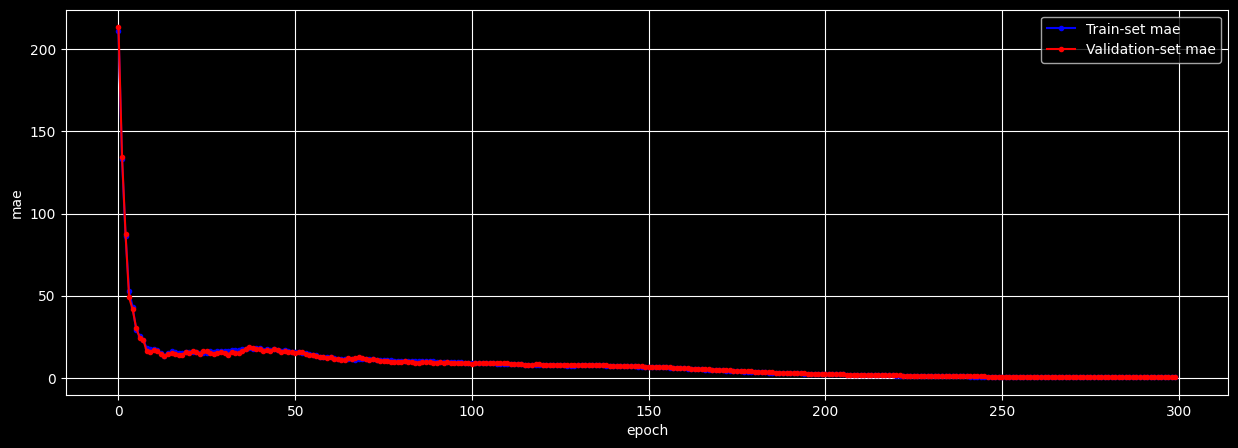

rmse


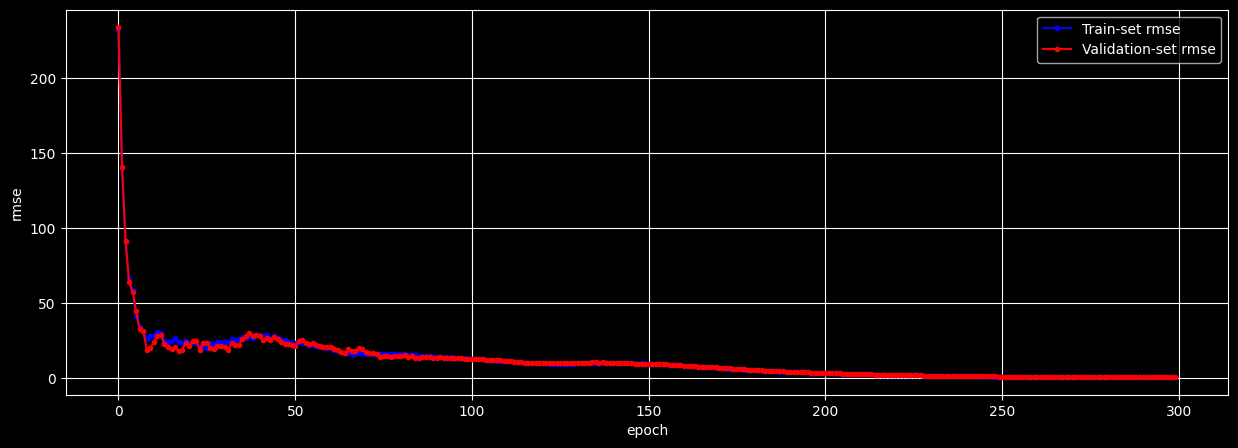

rmsle


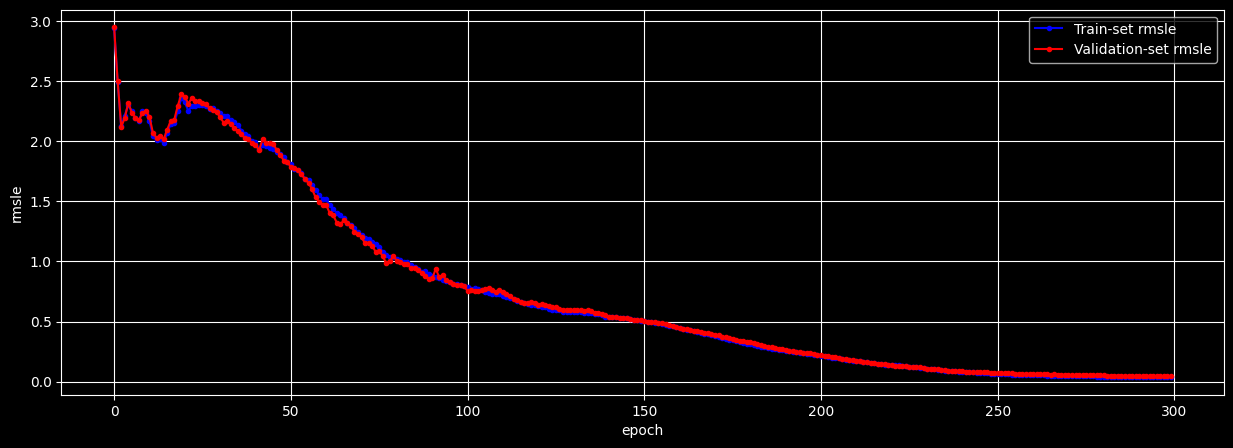

In [ ]:
# error
import numpy as np
error_list = ['mse', 'mae', 'rmse', 'rmsle']

for i in error_list:
  train_error = f'train_{i}'
  val_error = f'valid_{i}'

  train_error = reg.history[train_error]
  val_error = reg.history[val_error]

  x_len = np.arange(len(val_error))
  plt.figure(figsize=(15, 5))
  plt.plot(x_len, train_error, marker='.', c='blue', label=f"Train-set {i}")
  plt.plot(x_len, val_error, marker='.', c='red', label=f"Validation-set {i}")

  plt.legend(loc='upper right')
  plt.grid()
  plt.xlabel('epoch')
  plt.ylabel(f'{i}')

  print(f"{i}")
  plt.show()

In [ ]:
# ▶ TabNet test data 측정
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error

pred_dict = dict()
preds = reg.predict(X_test)

pred_dict['MAE']=mean_absolute_error(y_test, preds)
pred_dict['MSE'] = mean_squared_error(y_test, preds)
pred_dict['RMSE'] = mean_squared_error(y_test, preds)**0.5
pred_dict['RSMLE'] = mean_squared_log_error(y_test, preds)**0.5

for key, value in pred_dict.items():
  print(key, ' Score:', value)

MAE  Score: 0.41635695315844706
MSE  Score: 0.30980462336911085
RMSE  Score: 0.5566009552355358
RSMLE  Score: 0.043065541418079445


**┗ MLP 모델 예측**  

In [ ]:
df = all_data[features_list]

# 범주형 변수 LabelEncoding

from sklearn.preprocessing import LabelEncoder

c_features = categorical_list
categorical_columns = []
categorical_dims =  {}

for col in c_features:
    print(col, df[col].nunique())
    l_enc = LabelEncoder()
    df[col] = l_enc.fit_transform(df[col].values)
    categorical_columns.append(col)
    categorical_dims[col] = len(l_enc.classes_)

MSZoning 6
Alley 3
LotShape 4
LandContour 4
LotConfig 5
Neighborhood 25
Condition1 9
Condition2 8
BldgType 5
HouseStyle 8
RoofStyle 6
RoofMatl 8
Exterior1st 16
Exterior2nd 17
MasVnrType 4
ExterQual 4
ExterCond 5
Foundation 6
BsmtQual 5
BsmtCond 5
BsmtExposure 5
BsmtFinType1 7
BsmtFinType2 7
Heating 6
HeatingQC 5
CentralAir 2
Electrical 6
KitchenQual 5
FireplaceQu 6
GarageType 7
GarageFinish 4
GarageQual 6
GarageCond 6
PavedDrive 3
Fence 5
SaleType 10
SaleCondition 6


In [ ]:
from sklearn import preprocessing

X_train = df.drop(columns='SalePrice')
y_train = df[[target]]

X_valid = df.drop(columns='SalePrice')
y_valid = df[[target]]

X_test = df.drop(columns='SalePrice')
y_test = df[[target]]

In [ ]:
# Outlier 영향을 최소화하기 위해 RobustScaler 사용

scaler_x = preprocessing.RobustScaler()
X_train[X_train.columns] = scaler_x.fit_transform(X_train[X_train.columns])
X_valid[X_valid.columns] = scaler_x.transform(X_valid[X_valid.columns])
X_test[X_test.columns] = scaler_x.transform(X_test[X_test.columns])

In [ ]:
X_train = X_train.values[train_indices]
y_train = y_train[target].values[train_indices].reshape(-1, 1)

X_valid = X_valid[features].values[valid_indices]
y_valid = y_valid[target].values[valid_indices].reshape(-1, 1)

X_test = X_test[features].values[test_indices]
y_test = y_test[target].values[test_indices].reshape(-1, 1)

In [ ]:
# DataLoader 생성

trainX_tensor = torch.FloatTensor(X_train)
trainY_tensor = torch.FloatTensor(y_train)

valX_tensor = torch.FloatTensor(X_valid)
valY_tensor = torch.FloatTensor(y_valid)

testX_tensor = torch.FloatTensor(X_test)
testY_tensor = torch.FloatTensor(y_test)

batch = 50

train_dataset = TensorDataset(trainX_tensor, trainY_tensor)
val_dataset = TensorDataset(valX_tensor, valY_tensor)
test_dataset = TensorDataset(testX_tensor, testY_tensor)

train_dataloader = DataLoader(train_dataset,
                        batch_size = batch,
                        shuffle=True,
                        drop_last=True)

val_dataloader = DataLoader(val_dataset,
                        batch_size = batch,
                        shuffle=True,
                        drop_last=True)

test_dataloader = DataLoader(test_dataset,
                        batch_size = batch,
                        shuffle=True,
                        drop_last=True)

In [ ]:
n_input_dim = X_train.shape[1]

class Regressor(nn.Module):
    # ▶ 사용하기 위한 기본 함수들을 사전의 정의(self)
    def __init__(self):
        super(Regressor,self).__init__()
        self.fc1 = nn.Linear(n_input_dim, 300, bias=True)
        self.fc2 = nn.Linear(300, 100, bias=True)
        self.fc3 = nn.Linear(100, 1, bias=True)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    # ▶ 순전파(forward network) 구성, forward process만 구성하면 backword는 자동을 구성됨(autograd, 자동미분)
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.relu(self.fc3(x))
        return x

model = Regressor()
print(model)

Regressor(
  (fc1): Linear(in_features=57, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)


In [ ]:
# model 생성
model = Regressor()

In [ ]:
def train_model(model, train_df, val_df, learning_rate=None, num_epochs=None, verbose=20, patience=300):
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-7)
    train_hist = []
    val_hist = []
    for t in range(num_epochs):

        epoch_loss = 0

        for batch_idx, samples in enumerate(train_df):

            x_train, y_train = samples
            y_pred = model(x_train)
            loss = criterion(y_pred, y_train)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        train_hist.append(epoch_loss / len(train_df))

        if val_df is not None:

            with torch.no_grad():

                val_loss = 0

                for val_batch_idx, val_samples in enumerate(val_df):

                    x_val, y_val = samples

                    val_pred = model(x_val)
                    val_step_loss = criterion(val_pred, y_val)

                    val_loss += val_step_loss

            val_hist.append(val_loss / len(val_df))


            if t % verbose == 0:
                print(f'Epoch {t} train loss: {epoch_loss / len(train_df)} val loss: {val_loss / len(val_df)}')


            if (t % patience == 0) & (t != 0):


                if val_hist[t - patience] < val_hist[t] :

                    print('\n Early Stopping')

                    break

        elif t % verbose == 0:
            print(f'Epoch {t} train loss: {epoch_loss / len(train_df)}')


    return model, train_hist, val_hist

In [ ]:
model, train_hist, val_hist = train_model(
    model,
    train_dataloader,
    val_dataloader,
    learning_rate=1e-3,
    num_epochs=300,
)

Epoch 0 train loss: 58.61813961941263 val loss: 9.317426681518555
Epoch 20 train loss: 1.0793516311956488 val loss: 0.9500318765640259
Epoch 40 train loss: 1.0334498208502065 val loss: 0.9092198610305786
Epoch 60 train loss: 0.9393321871757507 val loss: 0.9525219798088074
Epoch 80 train loss: 0.9078369658926259 val loss: 0.8424232602119446
Epoch 100 train loss: 0.9219341297512469 val loss: 0.9561406373977661
Epoch 120 train loss: 0.8453717037387516 val loss: 0.8667671084403992
Epoch 140 train loss: 0.7597743603198425 val loss: 0.7639464139938354
Epoch 160 train loss: 0.739292495276617 val loss: 0.7127008438110352
Epoch 180 train loss: 0.7177564754434254 val loss: 0.6694504618644714
Epoch 200 train loss: 0.6185384217811667 val loss: 0.6135895848274231
Epoch 220 train loss: 0.6229318846826968 val loss: 0.6849676370620728
Epoch 240 train loss: 0.5503186424789221 val loss: 0.4584595263004303
Epoch 260 train loss: 0.5340290250985519 val loss: 0.408027321100235
Epoch 280 train loss: 0.507539

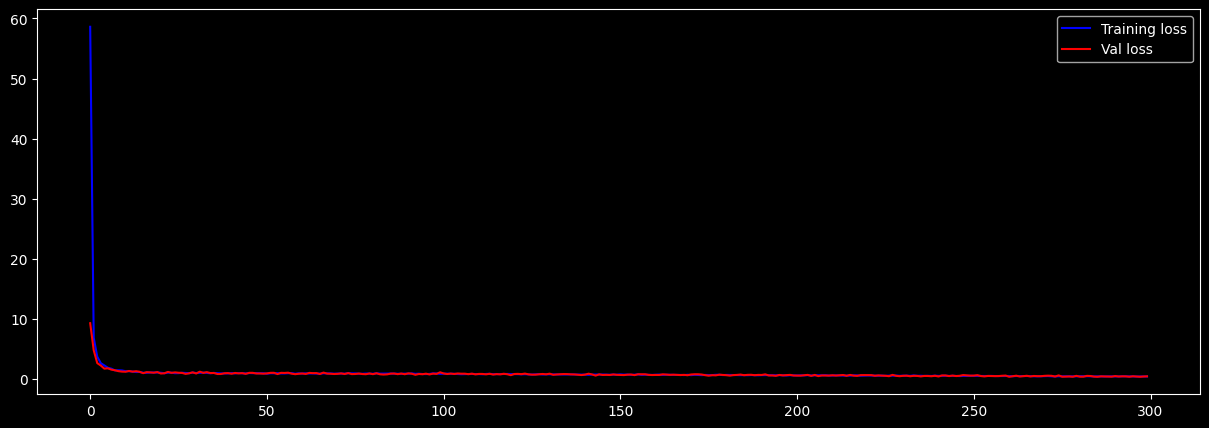

In [ ]:
plt.figure(figsize=(15, 5))

plt.plot(train_hist,  c='blue', label="Training loss")
plt.plot(val_hist, c='red', label="Val loss")
plt.legend()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
model.eval()
with torch.no_grad():
    pred = []


    for test_batch_idx, test_samples in enumerate(test_dataloader):

        x_test, y_test = test_samples
        preds = model(x_test)

    print('MAE SCORE : ', mean_absolute_error(preds, y_test))
    print('MSE SCORE : ', mean_squared_error(preds, y_test))
    print('RMSE SCORE : ', mean_squared_error(preds, y_test)**0.5)
    print('MAPE SCORE : ', mean_squared_log_error(preds, y_test, )**0.5)

MAE SCORE :  0.1405399
MSE SCORE :  0.03458517
RMSE SCORE :  0.1859708860220502
MAPE SCORE :  0.013947587526398414


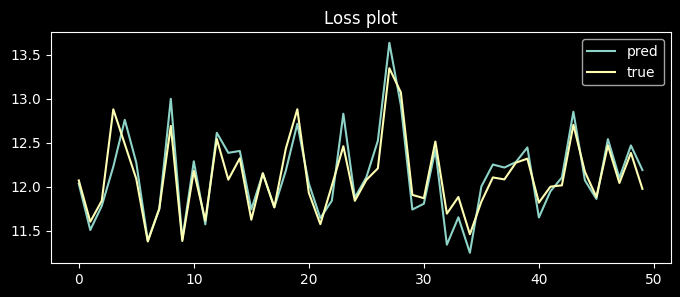

In [ ]:
# ▶ train loss 출력
fig = plt.figure(figsize=(8,3))
plt.plot(np.arange(len(preds)), preds, label = 'pred')
plt.plot(np.arange(len(y_test)), y_test, label = 'true')
plt.title("Loss plot")
plt.legend()
plt.show()

### · 변수 중요도 분석(Global, Local)


In [ ]:
# ▶ train, valid, test data 재설정
X_train = df[features].values[train_indices]
y_train = df[target].values[train_indices].reshape(-1, 1)

X_valid = df[features].values[valid_indices]
y_valid = df[target].values[valid_indices].reshape(-1, 1)

X_test = df[features].values[test_indices]
y_test = df[target].values[test_indices].reshape(-1, 1)

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
        39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
        52., 53., 54., 55., 56.]),
 [Text(0.0, 0, 'OverallQual'),
  Text(1.0, 0, 'TotalSF'),
  Text(2.0, 0, 'GarageScore'),
  Text(3.0, 0, 'BsmtScore'),
  Text(4.0, 0, 'GrLivArea'),
  Text(5.0, 0, 'GarageCars'),
  Text(6.0, 0, 'GarageArea'),
  Text(7.0, 0, 'TotalBath'),
  Text(8.0, 0, 'TotalBsmtSF'),
  Text(9.0, 0, '1stFlrSF'),
  Text(10.0, 0, 'YrBltAndRemod'),
  Text(11.0, 0, 'YearBuilt'),
  Text(12.0, 0, 'FullBath'),
  Text(13.0, 0, 'YearRemodAdd'),
  Text(14.0, 0, 'GarageYrBlt'),
  Text(15.0, 0, 'MasVnrArea'),
  Text(16.0, 0, 'BsmtFinScore'),
  Text(17.0, 0, 'TotRmsAbvGrd'),
  Text(18.0, 0, 'Fireplaces'),
  Text(19.0, 0, 'BsmtFinSF1'),
  Text(20.0, 0, 'MSZoning'),
  Text(21.0, 0, 'Alley'),
  Text

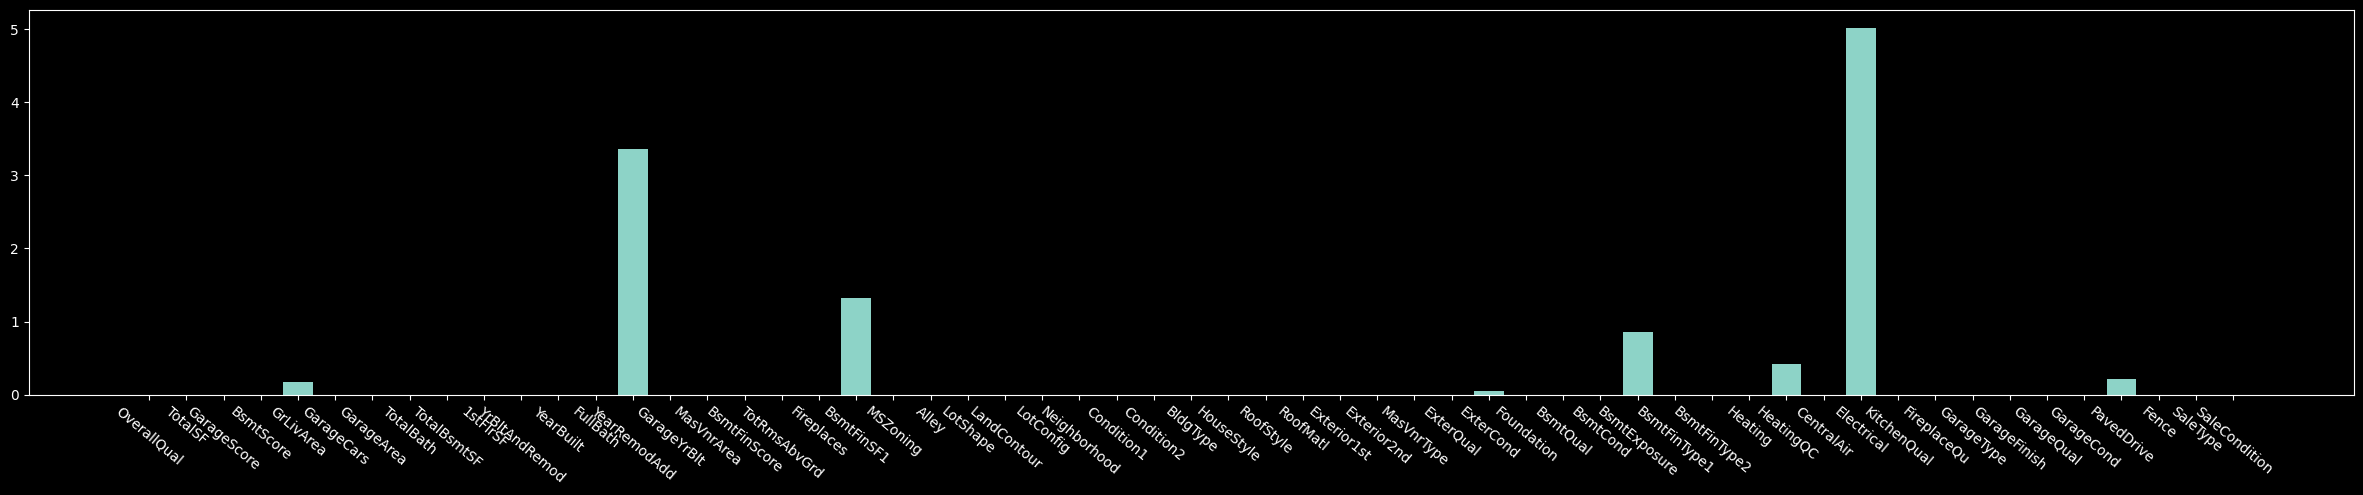

In [ ]:
# ▶ 개별 값 변수 중요도
# ▶ 영향을 끼친 변수는 0으로 출력
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.style.use(['dark_background'])

explain_matrix, masks = reg.explain(X_test)

fig = plt.figure(figsize=(30,5));
plt.bar(features_list[1:], explain_matrix[0]);
plt.xticks(features_list[1:]);
plt.xticks(rotation=-40)

In [ ]:
import plotly.express as px

# 중요도 정규화
# normalized_explain_mat = np.divide(explain_matrix, explain_matrix.sum(axis=1).reshape(-1, 1)+1e-8) # zero division error

test_preds = reg.predict(X_test)
explain_and_preds = np.hstack([explain_matrix, test_preds.reshape(-1, 1)])

px.imshow(explain_and_preds[:,:],
          labels=dict(x="Features", y="Samples", color="Local Importance"),
          x=features+["prediction"],
          title="Local Feature importance",
          color_continuous_scale='Jet',
          height=500)

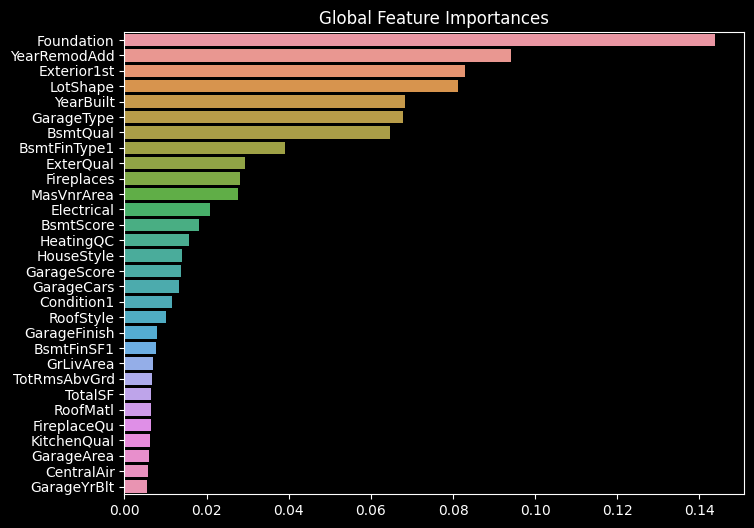

In [ ]:
# ▶ Global 영향도 확인
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use(['dark_background'])

ftr_importances_values = reg.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = features_list[1:])
ftr_top20 = ftr_importances.sort_values(ascending=False)[:30]

plt.figure(figsize=(8,6))
plt.title('Global Feature Importances')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()